# Reactome, KEGG, SMPDB

# Protein to Pathway (Reactome)

In [1]:
import pandas as pd
import numpy as npsmpd
import csv
import json
import biomedkg_utils
import os
from biomedkg_utils import *
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2

### Protein to Pathway

In [2]:
! wget -N -P input/ https://reactome.org/download/current/UniProt2Reactome_PE_Pathway.txt

protein2pathway, pathway2protein = dict(), dict()

with open('output/pathway2protein/edges_protein2reactomePathway.csv','w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Protein (UniProt)','Pathway (Reactome)', 'Relationship'])
    
    issue_lines = []
    with open('input/UniProt2Reactome_PE_Pathway.txt') as fin:
        for line in fin:
            nline = line.strip().split('\t')
            
            # Protein -involved in-> Pathway
            try:  
                species, protein, pathway = nline[7], nline[0], nline[3]
            
                if species.lower() == 'homo sapiens':
                    writer.writerow(['UniProt:'+protein, 'Reactome_Pathway:'+pathway, '-may_participate_in->'])
                    protein2pathway.setdefault(protein, set()).add(pathway)
                    pathway2protein.setdefault(pathway, set()).add(protein)

            # Save other lines with problems
            except: 
                if 'homo sapiens' in line.lower():
                    issue_lines.append(line)          

# Drop duplicates
df = pd.read_csv(open('output/pathway2protein/edges_protein2reactomePathway.csv')).drop_duplicates()
df.to_csv('output/pathway2protein/edges_protein2reactomePathway.csv')
                    
print('Human Reactome Protein-Pathway:', len(df))
df.head(3)

--2023-03-22 21:08:12--  https://reactome.org/download/current/UniProt2Reactome_PE_Pathway.txt
Resolving reactome.org (reactome.org)... 100.25.71.177
Connecting to reactome.org (reactome.org)|100.25.71.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83356080 (79M) [text/plain]
Saving to: ‘input/UniProt2Reactome_PE_Pathway.txt’

UniProt2Reactome_PE 100%[===================>]  79.49M  21.1MB/s    in 3.8s    

2023-03-22 21:08:17 (21.1 MB/s) - ‘input/UniProt2Reactome_PE_Pathway.txt’ saved [83356080/83356080]

Human Reactome Protein-Pathway: 46128


,Protein (UniProt),Pathway (Reactome),Relationship
0,UniProt:A0A075B6P5,Reactome_Pathway:R-HSA-166663,-may_participate_in->
1,UniProt:A0A075B6P5,Reactome_Pathway:R-HSA-173623,-may_participate_in->
2,UniProt:A0A075B6P5,Reactome_Pathway:R-HSA-198933,-may_participate_in->


In [3]:
# Could manually add some of these. 18 of 227,649 pathways weren't tab-delimited properly or were incomplete VVV
for line in issue_lines:
    print(line.strip().split('\t'))
    print(len(line.strip().split('\t')))

## Gene -in- Pathway

In [3]:
'''Load Gene-Pathway Data'''
os.system('wget -N -P input/ https://reactome.org/download/current/NCBI2Reactome_PE_Pathway.txt')
gene2pathway_df = pd.read_table('input/NCBI2Reactome_PE_Pathway.txt', low_memory=False)
gene2pathway_df.columns = ['Entrez Gene ID','Reactome Gene ID','Reactome Pathway Name','Reactome Pathway', 'Link', 'Pathway Name','Evidence','Species']
gene2pathway_df = gene2pathway_df[gene2pathway_df['Species']=='Homo sapiens'][['Entrez Gene ID','Reactome Gene ID', 'Reactome Pathway Name','Reactome Pathway']].drop_duplicates()
print(len(gene2pathway_df),'rows')
gene2pathway_df.head(3)

--2023-03-22 21:08:22--  https://reactome.org/download/current/NCBI2Reactome_PE_Pathway.txt
Resolving reactome.org (reactome.org)... 100.25.71.177
Connecting to reactome.org (reactome.org)|100.25.71.177|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘input/NCBI2Reactome_PE_Pathway.txt’ not modified on server. Omitting download.



73760 rows


,Entrez Gene ID,Reactome Gene ID,Reactome Pathway Name,Reactome Pathway
0,1,R-HSA-8848894,A1BG [platelet alpha granule lumen],R-HSA-114608
1,1,R-HSA-6801075,A1BG [ficolin-1-rich granule lumen],R-HSA-6798695
2,1,R-HSA-6806490,A1BG [extracellular region],R-HSA-6798695


In [4]:
'''Get Gene-Pathway Data'''
gene2pathway, pathway2gene = dict(), dict()

for i in range(0,len(gene2pathway_df)):
    entrez = gene2pathway_df['Entrez Gene ID'].iloc[i]
    pathway = gene2pathway_df['Reactome Pathway'].iloc[i]
    
    gene2pathway.setdefault(entrez, set()).add(pathway)
    pathway2gene.setdefault(pathway, set()).add(entrez)

'''Export Edges'''
file = 'Gene_(Entrez)_2_Pathway_(Reactome).csv'
outpath = os.path.join('output/pathway2gene',file)
output_edgefile_onerel_noweight(
    outpath = outpath,           
    columns = ['Gene (Entrez)','Pathway (Reactome)','Relationship'], 
    dictionary = gene2pathway, 
    rel = '-may_participate_in->', 
    prefix_col1='Entrez:', 
    prefix_col2='Reactome_Pathway:')

df = pd.read_csv('output/pathway2gene/edges_gene2reactomePathway.csv')
df.to_csv(os.path.join('output/edges',file),index=False)
df.to_csv(os.path.join('output/edges to use/',file),index=False)

print('Human Reactome Gene-Pathway:', len(df))
df.head(3)

Human Reactome Gene-Pathway: 44698


,Gene (Entrez),Pathway (Reactome),Relationship
0,Entrez:1,Reactome_Pathway:R-HSA-114608,-may_participate_in->
1,Entrez:1,Reactome_Pathway:R-HSA-6798695,-may_participate_in->
2,Entrez:10,Reactome_Pathway:R-HSA-9753281,-may_participate_in->


In [ ]:
# Add edges to use outpath

# then fix the KEGG issue

then check it and fix the GO issue in ca prot

## More Protein -in-Pathway

In [5]:
'''Get Gene-protein-Pathway Data'''

# Load Gene-Protein Data
gene2protein = json.load(open('output/protein2gene/all_entrez2uniprot.json'))
    
protein2pathway_viagene = dict()
proteinless_genes2pathway = dict()

# Protein -involved in- Pathway
for gene, pathways in gene2pathway.items():

    try: 
        # Protein -involved in- Pathway
        proteins = gene2protein[str(gene)]
        if len(proteins) == 1: # Proteins that share a gene might not all particiapte in the same pathway, so to be safe, we will only infer a protein's involvement in a pathway from a gene's involvedment in the pathway if the gene encodes for one known protein
            for protein in proteins:
                for pathway in pathways:
                    protein2pathway_viagene.setdefault(protein, set()).add(pathway)

    except: 
        # Proteinless Gene -involved in- Pathway
        for pathway in pathways:
            proteinless_genes2pathway.setdefault(str(gene),set()).add(pathway)

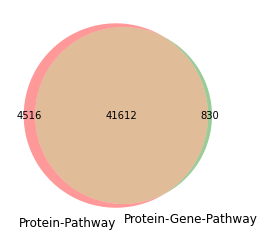

44698 gene-pathway relationships
44 gene-pathway relationships without proteins

46128 Protein-Pathway relationships (direct)
42442 Protein-Gene-Pathway relationships
46958 (Union) ^


In [6]:
'''Display Relationship Counts from Data Sources'''

def get_items_as_string_from_dict(d):
    d_items = set()
    for k,vs in d.items():
        for v in vs:
            d_items.add(str(k)+'|'+str(v))
    
    return d_items

s1 = get_items_as_string_from_dict(protein2pathway)
s2 = get_items_as_string_from_dict(protein2pathway_viagene)

venn2([s1, s2],\
      ("Protein-Pathway", "Protein-Gene-Pathway"));
plt.rc('font', size=12)
plt.show()

print(get_num_entries_in_dict(gene2pathway), 'gene-pathway relationships')           
print(get_num_entries_in_dict(proteinless_genes2pathway), 'gene-pathway relationships without proteins\n')
print(get_num_entries_in_dict(protein2pathway), 'Protein-Pathway relationships (direct)')
print(get_num_entries_in_dict(protein2pathway_viagene), 'Protein-Gene-Pathway relationships')
protein2pathway_both = merge_two_dictionaries_setvalues(protein2pathway_viagene, protein2pathway) # "|" operator might not be reliable so I did this
print(get_num_entries_in_dict(protein2pathway_both), '(Union) ^')

In [15]:
'''Export Edges'''
file = 'Protein_(UniProt)_2_Pathway_(Reactome).csv'


output_edgefile_onerel_noweight(
    outpath = 'output/pathway2protein/edges_protein2reactomePathway.csv',           
    columns = ['Protein (UniProt)','Pathway (Reactome)','Relationship'], 
    dictionary = protein2pathway_both, 
    rel = '-may_participate_in->', 
    prefix_col1='UniProt:',
    prefix_col2='Reactome_Pathway:')

df = pd.read_csv('output/pathway2protein/edges_protein2reactomePathway.csv')
df.to_csv(os.path.join('output/edges to use/', file), index=False)
print('Human Reactome Protein-Pathway:', len(df))
df.head(3)

Human Reactome Protein-Pathway: 46958


,Protein (UniProt),Pathway (Reactome),Relationship
0,UniProt:P04217,Reactome_Pathway:R-HSA-6798695,-may_participate_in->
1,UniProt:P04217,Reactome_Pathway:R-HSA-114608,-may_participate_in->
2,UniProt:P11245,Reactome_Pathway:R-HSA-156582,-may_participate_in->


#### Other Export

In [9]:
# Save proteins from protein-pathway relationships
prot2pw = pd.read_csv('output/pathway2protein/edges_protein2reactomePathway.csv')
prots = [prot.split(':')[1] for prot in set(prot2pw['Protein (UniProt)'])]
np.savetxt('output/protein2protein/ppi_input_fromproteinreactomepw.txt',list(prots),fmt ='% s')

# Gene & Protein to Pathway (KEGG)

### Edge: Gene to Pathway
Entrez Gene, KEGG Pathway

In [14]:
! curl https://rest.kegg.jp/link/pathway/hsa > input/KEGG/kegg_gene_to_pathway.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  812k    0  812k    0     0   156k      0 --:--:--  0:00:05 --:--:--  217k


In [16]:
''' Entrez Gene -in- KEGG Pathway '''
kegg_pathway_HAS_entrez_gene = dict()
entrez_gene_IN_kegg_pathway = dict()

with open('input/KEGG/kegg_gene_to_pathway.tsv') as fin:
    for line in fin:
        line = line.split('\t')
        kegg_gene = line[0].strip()
        kegg_pathway = line[1].strip().replace('path:','path_')
        
        try:
            entrez_gene = kegg_gene.split(':')[1]
            kegg_pathway_HAS_entrez_gene.setdefault(kegg_pathway,set()).add(entrez_gene)
            entrez_gene_IN_kegg_pathway.setdefault(entrez_gene,set()).add(kegg_pathway)
        except:
            continue        
            
print(len(kegg_pathway_HAS_entrez_gene), 'KEGG Pathways with Entrez Genes')
print(len(entrez_gene_IN_kegg_pathway), 'Entrez Genes with KEGG Pathways')

file = 'Gene_(Entrez)_2_Pathway_(KEGG).csv'
outpath = os.path.join('output/pathway2gene/',file)
output_edgefile_onerel_noweight(
    outpath = outpath,
    columns = ['Gene (Entrez)','Pathway (KEGG)','Relationship'],
    dictionary = entrez_gene_IN_kegg_pathway,
    rel = '-may_participate_in->',
    prefix_col1='Entrez:',
    prefix_col2='KEGG_Pathway:')

df = pd.read_csv(outpath)
df.to_csv(os.path.join('output/edges',file),index=False)
df.to_csv(os.path.join('output/edges to use',file), index=False)

352 KEGG Pathways with Entrez Genes
8292 Entrez Genes with KEGG Pathways


# Protein-Pathway SMPDB

In [18]:
import csv, os, pandas as pd, json, numpy as np
from biomedkg_utils import *

# Find compound-Pathway Pathways

In [19]:
compound2pw = json.load(open("output/compound2pathway/compound_to_pathway.json"))

pws = set()    
for pw_list in compound2pw.values():
    for pw in pw_list:
        pws.add(pw)
pws = list(pws)
pws.sort()

### Find pathways' proteins

In [20]:
! wget -N -P input/smpdb_files https://smpdb.ca/downloads/smpdb_pathways.csv.zip

--2023-03-22 21:13:43--  https://smpdb.ca/downloads/smpdb_pathways.csv.zip
Resolving smpdb.ca (smpdb.ca)... 162.243.73.221
Connecting to smpdb.ca (smpdb.ca)|162.243.73.221|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘input/smpdb_files/smpdb_pathways.csv.zip’ not modified on server. Omitting download.



In [9]:
!unzip input/smpdb_files/smpdb_proteins.csv.zip -d input/smpdb_files

Archive:  input/smpdb_files/smpdb_proteins.csv.zip
  inflating: input/smpdb_files/SMP0000055_proteins.csv  
  inflating: input/smpdb_files/SMP0000067_proteins.csv  
  inflating: input/smpdb_files/SMP0000072_proteins.csv  
  inflating: input/smpdb_files/SMP0000015_proteins.csv  
  inflating: input/smpdb_files/SMP0000057_proteins.csv  
  inflating: input/smpdb_files/SMP0000018_proteins.csv  
  inflating: input/smpdb_files/SMP0000029_proteins.csv  
  inflating: input/smpdb_files/SMP0000045_proteins.csv  
  inflating: input/smpdb_files/SMP0000009_proteins.csv  
  inflating: input/smpdb_files/SMP0000020_proteins.csv  
  inflating: input/smpdb_files/SMP0000007_proteins.csv  
  inflating: input/smpdb_files/SMP0000123_proteins.csv  
  inflating: input/smpdb_files/SMP0000066_proteins.csv  
  inflating: input/smpdb_files/SMP0000073_proteins.csv  
  inflating: input/smpdb_files/SMP0000028_proteins.csv  
  inflating: input/smpdb_files/SMP0000465_proteins.csv  
  inflating: input/smpdb_files/SMP000

  inflating: input/smpdb_files/SMP0000034_proteins.csv  
  inflating: input/smpdb_files/SMP0000016_proteins.csv  
  inflating: input/smpdb_files/SMP0000058_proteins.csv  
  inflating: input/smpdb_files/SMP0000048_proteins.csv  
  inflating: input/smpdb_files/SMP0000128_proteins.csv  
  inflating: input/smpdb_files/SMP0000457_proteins.csv  
  inflating: input/smpdb_files/SMP0000466_proteins.csv  
  inflating: input/smpdb_files/SMP0000030_proteins.csv  
  inflating: input/smpdb_files/SMP0000462_proteins.csv  
  inflating: input/smpdb_files/SMP0000004_proteins.csv  
  inflating: input/smpdb_files/SMP0000024_proteins.csv  
  inflating: input/smpdb_files/SMP0000043_proteins.csv  
  inflating: input/smpdb_files/SMP0000046_proteins.csv  
  inflating: input/smpdb_files/SMP0000052_proteins.csv  
  inflating: input/smpdb_files/SMP0000059_proteins.csv  
  inflating: input/smpdb_files/SMP0000063_proteins.csv  
  inflating: input/smpdb_files/SMP0000074_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0000233_proteins.csv  
  inflating: input/smpdb_files/SMP0000246_proteins.csv  
  inflating: input/smpdb_files/SMP0000078_proteins.csv  
  inflating: input/smpdb_files/SMP0000080_proteins.csv  
  inflating: input/smpdb_files/SMP0000081_proteins.csv  
  inflating: input/smpdb_files/SMP0000088_proteins.csv  
  inflating: input/smpdb_files/SMP0000090_proteins.csv  
  inflating: input/smpdb_files/SMP0000091_proteins.csv  
  inflating: input/smpdb_files/SMP0000097_proteins.csv  
  inflating: input/smpdb_files/SMP0000100_proteins.csv  
  inflating: input/smpdb_files/SMP0000103_proteins.csv  
  inflating: input/smpdb_files/SMP0000105_proteins.csv  
  inflating: input/smpdb_files/SMP0000108_proteins.csv  
  inflating: input/smpdb_files/SMP0000110_proteins.csv  
  inflating: input/smpdb_files/SMP0000115_proteins.csv  
  inflating: input/smpdb_files/SMP0000118_proteins.csv  
  inflating: input/smpdb_files/SMP0000121_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0000538_proteins.csv  
  inflating: input/smpdb_files/SMP0000539_proteins.csv  
  inflating: input/smpdb_files/SMP0000540_proteins.csv  
  inflating: input/smpdb_files/SMP0000541_proteins.csv  
  inflating: input/smpdb_files/SMP0000542_proteins.csv  
  inflating: input/smpdb_files/SMP0000543_proteins.csv  
  inflating: input/smpdb_files/SMP0000544_proteins.csv  
  inflating: input/smpdb_files/SMP0000545_proteins.csv  
  inflating: input/smpdb_files/SMP0000546_proteins.csv  
  inflating: input/smpdb_files/SMP0000547_proteins.csv  
  inflating: input/smpdb_files/SMP0000548_proteins.csv  
  inflating: input/smpdb_files/SMP0000549_proteins.csv  
  inflating: input/smpdb_files/SMP0000550_proteins.csv  
  inflating: input/smpdb_files/SMP0000551_proteins.csv  
  inflating: input/smpdb_files/SMP0000552_proteins.csv  
  inflating: input/smpdb_files/SMP0000553_proteins.csv  
  inflating: input/smpdb_files/SMP0000554_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0014340_proteins.csv  
  inflating: input/smpdb_files/SMP0014341_proteins.csv  
  inflating: input/smpdb_files/SMP0014342_proteins.csv  
  inflating: input/smpdb_files/SMP0014343_proteins.csv  
  inflating: input/smpdb_files/SMP0014344_proteins.csv  
  inflating: input/smpdb_files/SMP0014345_proteins.csv  
  inflating: input/smpdb_files/SMP0014346_proteins.csv  
  inflating: input/smpdb_files/SMP0014347_proteins.csv  
  inflating: input/smpdb_files/SMP0014348_proteins.csv  
  inflating: input/smpdb_files/SMP0014349_proteins.csv  
  inflating: input/smpdb_files/SMP0014350_proteins.csv  
  inflating: input/smpdb_files/SMP0014351_proteins.csv  
  inflating: input/smpdb_files/SMP0014352_proteins.csv  
  inflating: input/smpdb_files/SMP0014353_proteins.csv  
  inflating: input/smpdb_files/SMP0014354_proteins.csv  
  inflating: input/smpdb_files/SMP0014355_proteins.csv  
  inflating: input/smpdb_files/SMP0014356_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0014557_proteins.csv  
  inflating: input/smpdb_files/SMP0014558_proteins.csv  
  inflating: input/smpdb_files/SMP0014559_proteins.csv  
  inflating: input/smpdb_files/SMP0014560_proteins.csv  
  inflating: input/smpdb_files/SMP0014561_proteins.csv  
  inflating: input/smpdb_files/SMP0014562_proteins.csv  
  inflating: input/smpdb_files/SMP0014563_proteins.csv  
  inflating: input/smpdb_files/SMP0014564_proteins.csv  
  inflating: input/smpdb_files/SMP0014565_proteins.csv  
  inflating: input/smpdb_files/SMP0014566_proteins.csv  
  inflating: input/smpdb_files/SMP0014567_proteins.csv  
  inflating: input/smpdb_files/SMP0014568_proteins.csv  
  inflating: input/smpdb_files/SMP0014569_proteins.csv  
  inflating: input/smpdb_files/SMP0014570_proteins.csv  
  inflating: input/smpdb_files/SMP0014571_proteins.csv  
  inflating: input/smpdb_files/SMP0014572_proteins.csv  
  inflating: input/smpdb_files/SMP0014573_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0014730_proteins.csv  
  inflating: input/smpdb_files/SMP0014731_proteins.csv  
  inflating: input/smpdb_files/SMP0014732_proteins.csv  
  inflating: input/smpdb_files/SMP0014733_proteins.csv  
  inflating: input/smpdb_files/SMP0014734_proteins.csv  
  inflating: input/smpdb_files/SMP0014735_proteins.csv  
  inflating: input/smpdb_files/SMP0014736_proteins.csv  
  inflating: input/smpdb_files/SMP0014737_proteins.csv  
  inflating: input/smpdb_files/SMP0014738_proteins.csv  
  inflating: input/smpdb_files/SMP0014739_proteins.csv  
  inflating: input/smpdb_files/SMP0014740_proteins.csv  
  inflating: input/smpdb_files/SMP0014741_proteins.csv  
  inflating: input/smpdb_files/SMP0014742_proteins.csv  
  inflating: input/smpdb_files/SMP0014743_proteins.csv  
  inflating: input/smpdb_files/SMP0014744_proteins.csv  
  inflating: input/smpdb_files/SMP0014745_proteins.csv  
  inflating: input/smpdb_files/SMP0014746_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0015038_proteins.csv  
  inflating: input/smpdb_files/SMP0015039_proteins.csv  
  inflating: input/smpdb_files/SMP0015040_proteins.csv  
  inflating: input/smpdb_files/SMP0015041_proteins.csv  
  inflating: input/smpdb_files/SMP0015042_proteins.csv  
  inflating: input/smpdb_files/SMP0015043_proteins.csv  
  inflating: input/smpdb_files/SMP0015044_proteins.csv  
  inflating: input/smpdb_files/SMP0015045_proteins.csv  
  inflating: input/smpdb_files/SMP0015046_proteins.csv  
  inflating: input/smpdb_files/SMP0015047_proteins.csv  
  inflating: input/smpdb_files/SMP0015048_proteins.csv  
  inflating: input/smpdb_files/SMP0015049_proteins.csv  
  inflating: input/smpdb_files/SMP0015050_proteins.csv  
  inflating: input/smpdb_files/SMP0015051_proteins.csv  
  inflating: input/smpdb_files/SMP0015052_proteins.csv  
  inflating: input/smpdb_files/SMP0015053_proteins.csv  
  inflating: input/smpdb_files/SMP0015054_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0015239_proteins.csv  
  inflating: input/smpdb_files/SMP0015240_proteins.csv  
  inflating: input/smpdb_files/SMP0015241_proteins.csv  
  inflating: input/smpdb_files/SMP0015242_proteins.csv  
  inflating: input/smpdb_files/SMP0015243_proteins.csv  
  inflating: input/smpdb_files/SMP0015244_proteins.csv  
  inflating: input/smpdb_files/SMP0015245_proteins.csv  
  inflating: input/smpdb_files/SMP0015246_proteins.csv  
  inflating: input/smpdb_files/SMP0015247_proteins.csv  
  inflating: input/smpdb_files/SMP0015248_proteins.csv  
  inflating: input/smpdb_files/SMP0015249_proteins.csv  
  inflating: input/smpdb_files/SMP0015250_proteins.csv  
  inflating: input/smpdb_files/SMP0015251_proteins.csv  
  inflating: input/smpdb_files/SMP0015252_proteins.csv  
  inflating: input/smpdb_files/SMP0015253_proteins.csv  
  inflating: input/smpdb_files/SMP0015254_proteins.csv  
  inflating: input/smpdb_files/SMP0015255_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0015652_proteins.csv  
  inflating: input/smpdb_files/SMP0015653_proteins.csv  
  inflating: input/smpdb_files/SMP0015654_proteins.csv  
  inflating: input/smpdb_files/SMP0015655_proteins.csv  
  inflating: input/smpdb_files/SMP0015656_proteins.csv  
  inflating: input/smpdb_files/SMP0015657_proteins.csv  
  inflating: input/smpdb_files/SMP0015658_proteins.csv  
  inflating: input/smpdb_files/SMP0015659_proteins.csv  
  inflating: input/smpdb_files/SMP0015660_proteins.csv  
  inflating: input/smpdb_files/SMP0015661_proteins.csv  
  inflating: input/smpdb_files/SMP0015662_proteins.csv  
  inflating: input/smpdb_files/SMP0015663_proteins.csv  
  inflating: input/smpdb_files/SMP0015664_proteins.csv  
  inflating: input/smpdb_files/SMP0015665_proteins.csv  
  inflating: input/smpdb_files/SMP0015666_proteins.csv  
  inflating: input/smpdb_files/SMP0015667_proteins.csv  
  inflating: input/smpdb_files/SMP0015668_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0015799_proteins.csv  
  inflating: input/smpdb_files/SMP0015800_proteins.csv  
  inflating: input/smpdb_files/SMP0015801_proteins.csv  
  inflating: input/smpdb_files/SMP0015802_proteins.csv  
  inflating: input/smpdb_files/SMP0015803_proteins.csv  
  inflating: input/smpdb_files/SMP0015804_proteins.csv  
  inflating: input/smpdb_files/SMP0015805_proteins.csv  
  inflating: input/smpdb_files/SMP0015806_proteins.csv  
  inflating: input/smpdb_files/SMP0015807_proteins.csv  
  inflating: input/smpdb_files/SMP0015808_proteins.csv  
  inflating: input/smpdb_files/SMP0015809_proteins.csv  
  inflating: input/smpdb_files/SMP0015810_proteins.csv  
  inflating: input/smpdb_files/SMP0015811_proteins.csv  
  inflating: input/smpdb_files/SMP0015812_proteins.csv  
  inflating: input/smpdb_files/SMP0015813_proteins.csv  
  inflating: input/smpdb_files/SMP0015814_proteins.csv  
  inflating: input/smpdb_files/SMP0015815_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0016240_proteins.csv  
  inflating: input/smpdb_files/SMP0016241_proteins.csv  
  inflating: input/smpdb_files/SMP0016242_proteins.csv  
  inflating: input/smpdb_files/SMP0016243_proteins.csv  
  inflating: input/smpdb_files/SMP0016244_proteins.csv  
  inflating: input/smpdb_files/SMP0016245_proteins.csv  
  inflating: input/smpdb_files/SMP0016246_proteins.csv  
  inflating: input/smpdb_files/SMP0016247_proteins.csv  
  inflating: input/smpdb_files/SMP0016248_proteins.csv  
  inflating: input/smpdb_files/SMP0016249_proteins.csv  
  inflating: input/smpdb_files/SMP0016250_proteins.csv  
  inflating: input/smpdb_files/SMP0016251_proteins.csv  
  inflating: input/smpdb_files/SMP0016252_proteins.csv  
  inflating: input/smpdb_files/SMP0016253_proteins.csv  
  inflating: input/smpdb_files/SMP0016254_proteins.csv  
  inflating: input/smpdb_files/SMP0016255_proteins.csv  
  inflating: input/smpdb_files/SMP0016256_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0016408_proteins.csv  
  inflating: input/smpdb_files/SMP0016409_proteins.csv  
  inflating: input/smpdb_files/SMP0016410_proteins.csv  
  inflating: input/smpdb_files/SMP0016411_proteins.csv  
  inflating: input/smpdb_files/SMP0016412_proteins.csv  
  inflating: input/smpdb_files/SMP0016413_proteins.csv  
  inflating: input/smpdb_files/SMP0016414_proteins.csv  
  inflating: input/smpdb_files/SMP0016415_proteins.csv  
  inflating: input/smpdb_files/SMP0016416_proteins.csv  
  inflating: input/smpdb_files/SMP0016417_proteins.csv  
  inflating: input/smpdb_files/SMP0016418_proteins.csv  
  inflating: input/smpdb_files/SMP0016419_proteins.csv  
  inflating: input/smpdb_files/SMP0016420_proteins.csv  
  inflating: input/smpdb_files/SMP0016421_proteins.csv  
  inflating: input/smpdb_files/SMP0016422_proteins.csv  
  inflating: input/smpdb_files/SMP0016423_proteins.csv  
  inflating: input/smpdb_files/SMP0016424_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0017110_proteins.csv  
  inflating: input/smpdb_files/SMP0017111_proteins.csv  
  inflating: input/smpdb_files/SMP0017112_proteins.csv  
  inflating: input/smpdb_files/SMP0017113_proteins.csv  
  inflating: input/smpdb_files/SMP0017114_proteins.csv  
  inflating: input/smpdb_files/SMP0017115_proteins.csv  
  inflating: input/smpdb_files/SMP0017116_proteins.csv  
  inflating: input/smpdb_files/SMP0017117_proteins.csv  
  inflating: input/smpdb_files/SMP0017118_proteins.csv  
  inflating: input/smpdb_files/SMP0017119_proteins.csv  
  inflating: input/smpdb_files/SMP0017120_proteins.csv  
  inflating: input/smpdb_files/SMP0017121_proteins.csv  
  inflating: input/smpdb_files/SMP0017122_proteins.csv  
  inflating: input/smpdb_files/SMP0017123_proteins.csv  
  inflating: input/smpdb_files/SMP0017124_proteins.csv  
  inflating: input/smpdb_files/SMP0017125_proteins.csv  
  inflating: input/smpdb_files/SMP0017126_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0017827_proteins.csv  
  inflating: input/smpdb_files/SMP0017828_proteins.csv  
  inflating: input/smpdb_files/SMP0017829_proteins.csv  
  inflating: input/smpdb_files/SMP0017830_proteins.csv  
  inflating: input/smpdb_files/SMP0017831_proteins.csv  
  inflating: input/smpdb_files/SMP0017832_proteins.csv  
  inflating: input/smpdb_files/SMP0017833_proteins.csv  
  inflating: input/smpdb_files/SMP0017834_proteins.csv  
  inflating: input/smpdb_files/SMP0017835_proteins.csv  
  inflating: input/smpdb_files/SMP0017836_proteins.csv  
  inflating: input/smpdb_files/SMP0017837_proteins.csv  
  inflating: input/smpdb_files/SMP0017838_proteins.csv  
  inflating: input/smpdb_files/SMP0017839_proteins.csv  
  inflating: input/smpdb_files/SMP0017840_proteins.csv  
  inflating: input/smpdb_files/SMP0017841_proteins.csv  
  inflating: input/smpdb_files/SMP0017842_proteins.csv  
  inflating: input/smpdb_files/SMP0017843_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0018553_proteins.csv  
  inflating: input/smpdb_files/SMP0018554_proteins.csv  
  inflating: input/smpdb_files/SMP0018555_proteins.csv  
  inflating: input/smpdb_files/SMP0018556_proteins.csv  
  inflating: input/smpdb_files/SMP0018557_proteins.csv  
  inflating: input/smpdb_files/SMP0018558_proteins.csv  
  inflating: input/smpdb_files/SMP0018559_proteins.csv  
  inflating: input/smpdb_files/SMP0018560_proteins.csv  
  inflating: input/smpdb_files/SMP0018561_proteins.csv  
  inflating: input/smpdb_files/SMP0018562_proteins.csv  
  inflating: input/smpdb_files/SMP0018563_proteins.csv  
  inflating: input/smpdb_files/SMP0018564_proteins.csv  
  inflating: input/smpdb_files/SMP0018565_proteins.csv  
  inflating: input/smpdb_files/SMP0018566_proteins.csv  
  inflating: input/smpdb_files/SMP0018567_proteins.csv  
  inflating: input/smpdb_files/SMP0018568_proteins.csv  
  inflating: input/smpdb_files/SMP0018569_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0019278_proteins.csv  
  inflating: input/smpdb_files/SMP0019279_proteins.csv  
  inflating: input/smpdb_files/SMP0019280_proteins.csv  
  inflating: input/smpdb_files/SMP0019281_proteins.csv  
  inflating: input/smpdb_files/SMP0019282_proteins.csv  
  inflating: input/smpdb_files/SMP0019283_proteins.csv  
  inflating: input/smpdb_files/SMP0019284_proteins.csv  
  inflating: input/smpdb_files/SMP0019285_proteins.csv  
  inflating: input/smpdb_files/SMP0019286_proteins.csv  
  inflating: input/smpdb_files/SMP0019287_proteins.csv  
  inflating: input/smpdb_files/SMP0019288_proteins.csv  
  inflating: input/smpdb_files/SMP0019289_proteins.csv  
  inflating: input/smpdb_files/SMP0019290_proteins.csv  
  inflating: input/smpdb_files/SMP0019291_proteins.csv  
  inflating: input/smpdb_files/SMP0019292_proteins.csv  
  inflating: input/smpdb_files/SMP0019293_proteins.csv  
  inflating: input/smpdb_files/SMP0019294_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0019677_proteins.csv  
  inflating: input/smpdb_files/SMP0019678_proteins.csv  
  inflating: input/smpdb_files/SMP0019679_proteins.csv  
  inflating: input/smpdb_files/SMP0019680_proteins.csv  
  inflating: input/smpdb_files/SMP0019681_proteins.csv  
  inflating: input/smpdb_files/SMP0019682_proteins.csv  
  inflating: input/smpdb_files/SMP0019683_proteins.csv  
  inflating: input/smpdb_files/SMP0019684_proteins.csv  
  inflating: input/smpdb_files/SMP0019685_proteins.csv  
  inflating: input/smpdb_files/SMP0019686_proteins.csv  
  inflating: input/smpdb_files/SMP0019687_proteins.csv  
  inflating: input/smpdb_files/SMP0019688_proteins.csv  
  inflating: input/smpdb_files/SMP0019689_proteins.csv  
  inflating: input/smpdb_files/SMP0019690_proteins.csv  
  inflating: input/smpdb_files/SMP0019691_proteins.csv  
  inflating: input/smpdb_files/SMP0019692_proteins.csv  
  inflating: input/smpdb_files/SMP0019693_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0019960_proteins.csv  
  inflating: input/smpdb_files/SMP0019961_proteins.csv  
  inflating: input/smpdb_files/SMP0019962_proteins.csv  
  inflating: input/smpdb_files/SMP0019963_proteins.csv  
  inflating: input/smpdb_files/SMP0019964_proteins.csv  
  inflating: input/smpdb_files/SMP0019965_proteins.csv  
  inflating: input/smpdb_files/SMP0019966_proteins.csv  
  inflating: input/smpdb_files/SMP0019967_proteins.csv  
  inflating: input/smpdb_files/SMP0019968_proteins.csv  
  inflating: input/smpdb_files/SMP0019969_proteins.csv  
  inflating: input/smpdb_files/SMP0019970_proteins.csv  
  inflating: input/smpdb_files/SMP0019971_proteins.csv  
  inflating: input/smpdb_files/SMP0019972_proteins.csv  
  inflating: input/smpdb_files/SMP0019973_proteins.csv  
  inflating: input/smpdb_files/SMP0019974_proteins.csv  
  inflating: input/smpdb_files/SMP0019975_proteins.csv  
  inflating: input/smpdb_files/SMP0019976_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0020243_proteins.csv  
  inflating: input/smpdb_files/SMP0020244_proteins.csv  
  inflating: input/smpdb_files/SMP0020245_proteins.csv  
  inflating: input/smpdb_files/SMP0020246_proteins.csv  
  inflating: input/smpdb_files/SMP0020247_proteins.csv  
  inflating: input/smpdb_files/SMP0020248_proteins.csv  
  inflating: input/smpdb_files/SMP0020249_proteins.csv  
  inflating: input/smpdb_files/SMP0020250_proteins.csv  
  inflating: input/smpdb_files/SMP0020251_proteins.csv  
  inflating: input/smpdb_files/SMP0020252_proteins.csv  
  inflating: input/smpdb_files/SMP0020253_proteins.csv  
  inflating: input/smpdb_files/SMP0020254_proteins.csv  
  inflating: input/smpdb_files/SMP0020255_proteins.csv  
  inflating: input/smpdb_files/SMP0020256_proteins.csv  
  inflating: input/smpdb_files/SMP0020257_proteins.csv  
  inflating: input/smpdb_files/SMP0020258_proteins.csv  
  inflating: input/smpdb_files/SMP0020259_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0020525_proteins.csv  
  inflating: input/smpdb_files/SMP0020526_proteins.csv  
  inflating: input/smpdb_files/SMP0020527_proteins.csv  
  inflating: input/smpdb_files/SMP0020528_proteins.csv  
  inflating: input/smpdb_files/SMP0020529_proteins.csv  
  inflating: input/smpdb_files/SMP0020530_proteins.csv  
  inflating: input/smpdb_files/SMP0020531_proteins.csv  
  inflating: input/smpdb_files/SMP0020532_proteins.csv  
  inflating: input/smpdb_files/SMP0020533_proteins.csv  
  inflating: input/smpdb_files/SMP0020534_proteins.csv  
  inflating: input/smpdb_files/SMP0020535_proteins.csv  
  inflating: input/smpdb_files/SMP0020536_proteins.csv  
  inflating: input/smpdb_files/SMP0020537_proteins.csv  
  inflating: input/smpdb_files/SMP0020538_proteins.csv  
  inflating: input/smpdb_files/SMP0020539_proteins.csv  
  inflating: input/smpdb_files/SMP0020540_proteins.csv  
  inflating: input/smpdb_files/SMP0020541_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0021105_proteins.csv  
  inflating: input/smpdb_files/SMP0021106_proteins.csv  
  inflating: input/smpdb_files/SMP0021107_proteins.csv  
  inflating: input/smpdb_files/SMP0021108_proteins.csv  
  inflating: input/smpdb_files/SMP0021109_proteins.csv  
  inflating: input/smpdb_files/SMP0021110_proteins.csv  
  inflating: input/smpdb_files/SMP0021111_proteins.csv  
  inflating: input/smpdb_files/SMP0021112_proteins.csv  
  inflating: input/smpdb_files/SMP0021113_proteins.csv  
  inflating: input/smpdb_files/SMP0021114_proteins.csv  
  inflating: input/smpdb_files/SMP0021115_proteins.csv  
  inflating: input/smpdb_files/SMP0021116_proteins.csv  
  inflating: input/smpdb_files/SMP0021117_proteins.csv  
  inflating: input/smpdb_files/SMP0021118_proteins.csv  
  inflating: input/smpdb_files/SMP0021119_proteins.csv  
  inflating: input/smpdb_files/SMP0021120_proteins.csv  
  inflating: input/smpdb_files/SMP0021121_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0021828_proteins.csv  
  inflating: input/smpdb_files/SMP0021829_proteins.csv  
  inflating: input/smpdb_files/SMP0021830_proteins.csv  
  inflating: input/smpdb_files/SMP0021831_proteins.csv  
  inflating: input/smpdb_files/SMP0021832_proteins.csv  
  inflating: input/smpdb_files/SMP0021833_proteins.csv  
  inflating: input/smpdb_files/SMP0021834_proteins.csv  
  inflating: input/smpdb_files/SMP0021835_proteins.csv  
  inflating: input/smpdb_files/SMP0021836_proteins.csv  
  inflating: input/smpdb_files/SMP0021837_proteins.csv  
  inflating: input/smpdb_files/SMP0021838_proteins.csv  
  inflating: input/smpdb_files/SMP0021839_proteins.csv  
  inflating: input/smpdb_files/SMP0021840_proteins.csv  
  inflating: input/smpdb_files/SMP0021841_proteins.csv  
  inflating: input/smpdb_files/SMP0021842_proteins.csv  
  inflating: input/smpdb_files/SMP0021843_proteins.csv  
  inflating: input/smpdb_files/SMP0021844_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0022543_proteins.csv  
  inflating: input/smpdb_files/SMP0022544_proteins.csv  
  inflating: input/smpdb_files/SMP0022545_proteins.csv  
  inflating: input/smpdb_files/SMP0022546_proteins.csv  
  inflating: input/smpdb_files/SMP0022547_proteins.csv  
  inflating: input/smpdb_files/SMP0022548_proteins.csv  
  inflating: input/smpdb_files/SMP0022549_proteins.csv  
  inflating: input/smpdb_files/SMP0022550_proteins.csv  
  inflating: input/smpdb_files/SMP0022551_proteins.csv  
  inflating: input/smpdb_files/SMP0022552_proteins.csv  
  inflating: input/smpdb_files/SMP0022553_proteins.csv  
  inflating: input/smpdb_files/SMP0022554_proteins.csv  
  inflating: input/smpdb_files/SMP0022555_proteins.csv  
  inflating: input/smpdb_files/SMP0022556_proteins.csv  
  inflating: input/smpdb_files/SMP0022557_proteins.csv  
  inflating: input/smpdb_files/SMP0022558_proteins.csv  
  inflating: input/smpdb_files/SMP0022559_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0023264_proteins.csv  
  inflating: input/smpdb_files/SMP0023265_proteins.csv  
  inflating: input/smpdb_files/SMP0023266_proteins.csv  
  inflating: input/smpdb_files/SMP0023267_proteins.csv  
  inflating: input/smpdb_files/SMP0023268_proteins.csv  
  inflating: input/smpdb_files/SMP0023269_proteins.csv  
  inflating: input/smpdb_files/SMP0023270_proteins.csv  
  inflating: input/smpdb_files/SMP0023271_proteins.csv  
  inflating: input/smpdb_files/SMP0023272_proteins.csv  
  inflating: input/smpdb_files/SMP0023273_proteins.csv  
  inflating: input/smpdb_files/SMP0023274_proteins.csv  
  inflating: input/smpdb_files/SMP0023275_proteins.csv  
  inflating: input/smpdb_files/SMP0023276_proteins.csv  
  inflating: input/smpdb_files/SMP0023277_proteins.csv  
  inflating: input/smpdb_files/SMP0023278_proteins.csv  
  inflating: input/smpdb_files/SMP0023279_proteins.csv  
  inflating: input/smpdb_files/SMP0023280_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0023978_proteins.csv  
  inflating: input/smpdb_files/SMP0023979_proteins.csv  
  inflating: input/smpdb_files/SMP0023980_proteins.csv  
  inflating: input/smpdb_files/SMP0023981_proteins.csv  
  inflating: input/smpdb_files/SMP0023982_proteins.csv  
  inflating: input/smpdb_files/SMP0023983_proteins.csv  
  inflating: input/smpdb_files/SMP0023984_proteins.csv  
  inflating: input/smpdb_files/SMP0023985_proteins.csv  
  inflating: input/smpdb_files/SMP0023986_proteins.csv  
  inflating: input/smpdb_files/SMP0023987_proteins.csv  
  inflating: input/smpdb_files/SMP0023988_proteins.csv  
  inflating: input/smpdb_files/SMP0023989_proteins.csv  
  inflating: input/smpdb_files/SMP0023990_proteins.csv  
  inflating: input/smpdb_files/SMP0023991_proteins.csv  
  inflating: input/smpdb_files/SMP0023992_proteins.csv  
  inflating: input/smpdb_files/SMP0023993_proteins.csv  
  inflating: input/smpdb_files/SMP0023994_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0024700_proteins.csv  
  inflating: input/smpdb_files/SMP0024701_proteins.csv  
  inflating: input/smpdb_files/SMP0024702_proteins.csv  
  inflating: input/smpdb_files/SMP0024703_proteins.csv  
  inflating: input/smpdb_files/SMP0024704_proteins.csv  
  inflating: input/smpdb_files/SMP0024705_proteins.csv  
  inflating: input/smpdb_files/SMP0024706_proteins.csv  
  inflating: input/smpdb_files/SMP0024707_proteins.csv  
  inflating: input/smpdb_files/SMP0024708_proteins.csv  
  inflating: input/smpdb_files/SMP0024709_proteins.csv  
  inflating: input/smpdb_files/SMP0024710_proteins.csv  
  inflating: input/smpdb_files/SMP0024711_proteins.csv  
  inflating: input/smpdb_files/SMP0024712_proteins.csv  
  inflating: input/smpdb_files/SMP0024713_proteins.csv  
  inflating: input/smpdb_files/SMP0024714_proteins.csv  
  inflating: input/smpdb_files/SMP0024715_proteins.csv  
  inflating: input/smpdb_files/SMP0024716_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0025364_proteins.csv  
  inflating: input/smpdb_files/SMP0025365_proteins.csv  
  inflating: input/smpdb_files/SMP0025366_proteins.csv  
  inflating: input/smpdb_files/SMP0025368_proteins.csv  
  inflating: input/smpdb_files/SMP0025369_proteins.csv  
  inflating: input/smpdb_files/SMP0025370_proteins.csv  
  inflating: input/smpdb_files/SMP0025371_proteins.csv  
  inflating: input/smpdb_files/SMP0025372_proteins.csv  
  inflating: input/smpdb_files/SMP0025373_proteins.csv  
  inflating: input/smpdb_files/SMP0025374_proteins.csv  
  inflating: input/smpdb_files/SMP0025375_proteins.csv  
  inflating: input/smpdb_files/SMP0025376_proteins.csv  
  inflating: input/smpdb_files/SMP0025377_proteins.csv  
  inflating: input/smpdb_files/SMP0025378_proteins.csv  
  inflating: input/smpdb_files/SMP0025379_proteins.csv  
  inflating: input/smpdb_files/SMP0025380_proteins.csv  
  inflating: input/smpdb_files/SMP0025381_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0026080_proteins.csv  
  inflating: input/smpdb_files/SMP0026081_proteins.csv  
  inflating: input/smpdb_files/SMP0026082_proteins.csv  
  inflating: input/smpdb_files/SMP0026083_proteins.csv  
  inflating: input/smpdb_files/SMP0026084_proteins.csv  
  inflating: input/smpdb_files/SMP0026085_proteins.csv  
  inflating: input/smpdb_files/SMP0026086_proteins.csv  
  inflating: input/smpdb_files/SMP0026087_proteins.csv  
  inflating: input/smpdb_files/SMP0026088_proteins.csv  
  inflating: input/smpdb_files/SMP0026089_proteins.csv  
  inflating: input/smpdb_files/SMP0026090_proteins.csv  
  inflating: input/smpdb_files/SMP0026091_proteins.csv  
  inflating: input/smpdb_files/SMP0026092_proteins.csv  
  inflating: input/smpdb_files/SMP0026093_proteins.csv  
  inflating: input/smpdb_files/SMP0026094_proteins.csv  
  inflating: input/smpdb_files/SMP0026095_proteins.csv  
  inflating: input/smpdb_files/SMP0026096_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0026805_proteins.csv  
  inflating: input/smpdb_files/SMP0026806_proteins.csv  
  inflating: input/smpdb_files/SMP0026807_proteins.csv  
  inflating: input/smpdb_files/SMP0026808_proteins.csv  
  inflating: input/smpdb_files/SMP0026809_proteins.csv  
  inflating: input/smpdb_files/SMP0026810_proteins.csv  
  inflating: input/smpdb_files/SMP0026811_proteins.csv  
  inflating: input/smpdb_files/SMP0026812_proteins.csv  
  inflating: input/smpdb_files/SMP0026813_proteins.csv  
  inflating: input/smpdb_files/SMP0026814_proteins.csv  
  inflating: input/smpdb_files/SMP0026815_proteins.csv  
  inflating: input/smpdb_files/SMP0026816_proteins.csv  
  inflating: input/smpdb_files/SMP0026817_proteins.csv  
  inflating: input/smpdb_files/SMP0026818_proteins.csv  
  inflating: input/smpdb_files/SMP0026819_proteins.csv  
  inflating: input/smpdb_files/SMP0026820_proteins.csv  
  inflating: input/smpdb_files/SMP0026821_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0027508_proteins.csv  
  inflating: input/smpdb_files/SMP0027509_proteins.csv  
  inflating: input/smpdb_files/SMP0027510_proteins.csv  
  inflating: input/smpdb_files/SMP0027511_proteins.csv  
  inflating: input/smpdb_files/SMP0027512_proteins.csv  
  inflating: input/smpdb_files/SMP0027513_proteins.csv  
  inflating: input/smpdb_files/SMP0027514_proteins.csv  
  inflating: input/smpdb_files/SMP0027515_proteins.csv  
  inflating: input/smpdb_files/SMP0027516_proteins.csv  
  inflating: input/smpdb_files/SMP0027517_proteins.csv  
  inflating: input/smpdb_files/SMP0027518_proteins.csv  
  inflating: input/smpdb_files/SMP0027519_proteins.csv  
  inflating: input/smpdb_files/SMP0027520_proteins.csv  
  inflating: input/smpdb_files/SMP0027521_proteins.csv  
  inflating: input/smpdb_files/SMP0027522_proteins.csv  
  inflating: input/smpdb_files/SMP0027523_proteins.csv  
  inflating: input/smpdb_files/SMP0027524_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0028195_proteins.csv  
  inflating: input/smpdb_files/SMP0028196_proteins.csv  
  inflating: input/smpdb_files/SMP0028197_proteins.csv  
  inflating: input/smpdb_files/SMP0028198_proteins.csv  
  inflating: input/smpdb_files/SMP0028199_proteins.csv  
  inflating: input/smpdb_files/SMP0028200_proteins.csv  
  inflating: input/smpdb_files/SMP0028201_proteins.csv  
  inflating: input/smpdb_files/SMP0028202_proteins.csv  
  inflating: input/smpdb_files/SMP0028203_proteins.csv  
  inflating: input/smpdb_files/SMP0028204_proteins.csv  
  inflating: input/smpdb_files/SMP0028205_proteins.csv  
  inflating: input/smpdb_files/SMP0028206_proteins.csv  
  inflating: input/smpdb_files/SMP0028207_proteins.csv  
  inflating: input/smpdb_files/SMP0028208_proteins.csv  
  inflating: input/smpdb_files/SMP0028209_proteins.csv  
  inflating: input/smpdb_files/SMP0028210_proteins.csv  
  inflating: input/smpdb_files/SMP0028211_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0028872_proteins.csv  
  inflating: input/smpdb_files/SMP0028873_proteins.csv  
  inflating: input/smpdb_files/SMP0028874_proteins.csv  
  inflating: input/smpdb_files/SMP0028875_proteins.csv  
  inflating: input/smpdb_files/SMP0028876_proteins.csv  
  inflating: input/smpdb_files/SMP0028877_proteins.csv  
  inflating: input/smpdb_files/SMP0028878_proteins.csv  
  inflating: input/smpdb_files/SMP0028879_proteins.csv  
  inflating: input/smpdb_files/SMP0028880_proteins.csv  
  inflating: input/smpdb_files/SMP0028881_proteins.csv  
  inflating: input/smpdb_files/SMP0028882_proteins.csv  
  inflating: input/smpdb_files/SMP0028883_proteins.csv  
  inflating: input/smpdb_files/SMP0028884_proteins.csv  
  inflating: input/smpdb_files/SMP0028885_proteins.csv  
  inflating: input/smpdb_files/SMP0028886_proteins.csv  
  inflating: input/smpdb_files/SMP0028887_proteins.csv  
  inflating: input/smpdb_files/SMP0028888_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0029554_proteins.csv  
  inflating: input/smpdb_files/SMP0029555_proteins.csv  
  inflating: input/smpdb_files/SMP0029556_proteins.csv  
  inflating: input/smpdb_files/SMP0029557_proteins.csv  
  inflating: input/smpdb_files/SMP0029558_proteins.csv  
  inflating: input/smpdb_files/SMP0029559_proteins.csv  
  inflating: input/smpdb_files/SMP0029560_proteins.csv  
  inflating: input/smpdb_files/SMP0029561_proteins.csv  
  inflating: input/smpdb_files/SMP0029562_proteins.csv  
  inflating: input/smpdb_files/SMP0029563_proteins.csv  
  inflating: input/smpdb_files/SMP0029564_proteins.csv  
  inflating: input/smpdb_files/SMP0029565_proteins.csv  
  inflating: input/smpdb_files/SMP0029566_proteins.csv  
  inflating: input/smpdb_files/SMP0029567_proteins.csv  
  inflating: input/smpdb_files/SMP0029568_proteins.csv  
  inflating: input/smpdb_files/SMP0029569_proteins.csv  
  inflating: input/smpdb_files/SMP0029570_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0029896_proteins.csv  
  inflating: input/smpdb_files/SMP0029897_proteins.csv  
  inflating: input/smpdb_files/SMP0029898_proteins.csv  
  inflating: input/smpdb_files/SMP0029899_proteins.csv  
  inflating: input/smpdb_files/SMP0029900_proteins.csv  
  inflating: input/smpdb_files/SMP0029901_proteins.csv  
  inflating: input/smpdb_files/SMP0029902_proteins.csv  
  inflating: input/smpdb_files/SMP0029903_proteins.csv  
  inflating: input/smpdb_files/SMP0029904_proteins.csv  
  inflating: input/smpdb_files/SMP0029905_proteins.csv  
  inflating: input/smpdb_files/SMP0029906_proteins.csv  
  inflating: input/smpdb_files/SMP0029907_proteins.csv  
  inflating: input/smpdb_files/SMP0029908_proteins.csv  
  inflating: input/smpdb_files/SMP0029909_proteins.csv  
  inflating: input/smpdb_files/SMP0029910_proteins.csv  
  inflating: input/smpdb_files/SMP0029911_proteins.csv  
  inflating: input/smpdb_files/SMP0029912_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0031717_proteins.csv  
  inflating: input/smpdb_files/SMP0031718_proteins.csv  
  inflating: input/smpdb_files/SMP0031719_proteins.csv  
  inflating: input/smpdb_files/SMP0031720_proteins.csv  
  inflating: input/smpdb_files/SMP0031721_proteins.csv  
  inflating: input/smpdb_files/SMP0031722_proteins.csv  
  inflating: input/smpdb_files/SMP0031723_proteins.csv  
  inflating: input/smpdb_files/SMP0031724_proteins.csv  
  inflating: input/smpdb_files/SMP0031725_proteins.csv  
  inflating: input/smpdb_files/SMP0031726_proteins.csv  
  inflating: input/smpdb_files/SMP0031727_proteins.csv  
  inflating: input/smpdb_files/SMP0031728_proteins.csv  
  inflating: input/smpdb_files/SMP0031729_proteins.csv  
  inflating: input/smpdb_files/SMP0031730_proteins.csv  
  inflating: input/smpdb_files/SMP0031731_proteins.csv  
  inflating: input/smpdb_files/SMP0031732_proteins.csv  
  inflating: input/smpdb_files/SMP0031733_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0032115_proteins.csv  
  inflating: input/smpdb_files/SMP0032116_proteins.csv  
  inflating: input/smpdb_files/SMP0032117_proteins.csv  
  inflating: input/smpdb_files/SMP0032118_proteins.csv  
  inflating: input/smpdb_files/SMP0032119_proteins.csv  
  inflating: input/smpdb_files/SMP0032120_proteins.csv  
  inflating: input/smpdb_files/SMP0032121_proteins.csv  
  inflating: input/smpdb_files/SMP0032122_proteins.csv  
  inflating: input/smpdb_files/SMP0032123_proteins.csv  
  inflating: input/smpdb_files/SMP0032124_proteins.csv  
  inflating: input/smpdb_files/SMP0032125_proteins.csv  
  inflating: input/smpdb_files/SMP0032126_proteins.csv  
  inflating: input/smpdb_files/SMP0032127_proteins.csv  
  inflating: input/smpdb_files/SMP0032128_proteins.csv  
  inflating: input/smpdb_files/SMP0032129_proteins.csv  
  inflating: input/smpdb_files/SMP0032130_proteins.csv  
  inflating: input/smpdb_files/SMP0032131_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0032697_proteins.csv  
  inflating: input/smpdb_files/SMP0032698_proteins.csv  
  inflating: input/smpdb_files/SMP0032699_proteins.csv  
  inflating: input/smpdb_files/SMP0032700_proteins.csv  
  inflating: input/smpdb_files/SMP0032701_proteins.csv  
  inflating: input/smpdb_files/SMP0032702_proteins.csv  
  inflating: input/smpdb_files/SMP0032703_proteins.csv  
  inflating: input/smpdb_files/SMP0032704_proteins.csv  
  inflating: input/smpdb_files/SMP0032705_proteins.csv  
  inflating: input/smpdb_files/SMP0032706_proteins.csv  
  inflating: input/smpdb_files/SMP0032707_proteins.csv  
  inflating: input/smpdb_files/SMP0032708_proteins.csv  
  inflating: input/smpdb_files/SMP0032709_proteins.csv  
  inflating: input/smpdb_files/SMP0032710_proteins.csv  
  inflating: input/smpdb_files/SMP0032711_proteins.csv  
  inflating: input/smpdb_files/SMP0032712_proteins.csv  
  inflating: input/smpdb_files/SMP0032713_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0033419_proteins.csv  
  inflating: input/smpdb_files/SMP0033420_proteins.csv  
  inflating: input/smpdb_files/SMP0033421_proteins.csv  
  inflating: input/smpdb_files/SMP0033422_proteins.csv  
  inflating: input/smpdb_files/SMP0033423_proteins.csv  
  inflating: input/smpdb_files/SMP0033424_proteins.csv  
  inflating: input/smpdb_files/SMP0033425_proteins.csv  
  inflating: input/smpdb_files/SMP0033426_proteins.csv  
  inflating: input/smpdb_files/SMP0033427_proteins.csv  
  inflating: input/smpdb_files/SMP0033428_proteins.csv  
  inflating: input/smpdb_files/SMP0033429_proteins.csv  
  inflating: input/smpdb_files/SMP0033430_proteins.csv  
  inflating: input/smpdb_files/SMP0033431_proteins.csv  
  inflating: input/smpdb_files/SMP0033432_proteins.csv  
  inflating: input/smpdb_files/SMP0033433_proteins.csv  
  inflating: input/smpdb_files/SMP0033434_proteins.csv  
  inflating: input/smpdb_files/SMP0033435_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0034143_proteins.csv  
  inflating: input/smpdb_files/SMP0034144_proteins.csv  
  inflating: input/smpdb_files/SMP0034145_proteins.csv  
  inflating: input/smpdb_files/SMP0034146_proteins.csv  
  inflating: input/smpdb_files/SMP0034147_proteins.csv  
  inflating: input/smpdb_files/SMP0034148_proteins.csv  
  inflating: input/smpdb_files/SMP0034149_proteins.csv  
  inflating: input/smpdb_files/SMP0034150_proteins.csv  
  inflating: input/smpdb_files/SMP0034151_proteins.csv  
  inflating: input/smpdb_files/SMP0034152_proteins.csv  
  inflating: input/smpdb_files/SMP0034153_proteins.csv  
  inflating: input/smpdb_files/SMP0034154_proteins.csv  
  inflating: input/smpdb_files/SMP0034155_proteins.csv  
  inflating: input/smpdb_files/SMP0034156_proteins.csv  
  inflating: input/smpdb_files/SMP0034157_proteins.csv  
  inflating: input/smpdb_files/SMP0034158_proteins.csv  
  inflating: input/smpdb_files/SMP0034159_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0034854_proteins.csv  
  inflating: input/smpdb_files/SMP0034855_proteins.csv  
  inflating: input/smpdb_files/SMP0034856_proteins.csv  
  inflating: input/smpdb_files/SMP0034857_proteins.csv  
  inflating: input/smpdb_files/SMP0034858_proteins.csv  
  inflating: input/smpdb_files/SMP0034859_proteins.csv  
  inflating: input/smpdb_files/SMP0034860_proteins.csv  
  inflating: input/smpdb_files/SMP0034861_proteins.csv  
  inflating: input/smpdb_files/SMP0034862_proteins.csv  
  inflating: input/smpdb_files/SMP0034863_proteins.csv  
  inflating: input/smpdb_files/SMP0034864_proteins.csv  
  inflating: input/smpdb_files/SMP0034865_proteins.csv  
  inflating: input/smpdb_files/SMP0034866_proteins.csv  
  inflating: input/smpdb_files/SMP0034867_proteins.csv  
  inflating: input/smpdb_files/SMP0034868_proteins.csv  
  inflating: input/smpdb_files/SMP0034869_proteins.csv  
  inflating: input/smpdb_files/SMP0034870_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0035569_proteins.csv  
  inflating: input/smpdb_files/SMP0035570_proteins.csv  
  inflating: input/smpdb_files/SMP0035571_proteins.csv  
  inflating: input/smpdb_files/SMP0035572_proteins.csv  
  inflating: input/smpdb_files/SMP0035573_proteins.csv  
  inflating: input/smpdb_files/SMP0035574_proteins.csv  
  inflating: input/smpdb_files/SMP0035575_proteins.csv  
  inflating: input/smpdb_files/SMP0035576_proteins.csv  
  inflating: input/smpdb_files/SMP0035577_proteins.csv  
  inflating: input/smpdb_files/SMP0035578_proteins.csv  
  inflating: input/smpdb_files/SMP0035579_proteins.csv  
  inflating: input/smpdb_files/SMP0035580_proteins.csv  
  inflating: input/smpdb_files/SMP0035581_proteins.csv  
  inflating: input/smpdb_files/SMP0035582_proteins.csv  
  inflating: input/smpdb_files/SMP0035583_proteins.csv  
  inflating: input/smpdb_files/SMP0035584_proteins.csv  
  inflating: input/smpdb_files/SMP0035585_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0036296_proteins.csv  
  inflating: input/smpdb_files/SMP0036297_proteins.csv  
  inflating: input/smpdb_files/SMP0036298_proteins.csv  
  inflating: input/smpdb_files/SMP0036299_proteins.csv  
  inflating: input/smpdb_files/SMP0036300_proteins.csv  
  inflating: input/smpdb_files/SMP0036301_proteins.csv  
  inflating: input/smpdb_files/SMP0036302_proteins.csv  
  inflating: input/smpdb_files/SMP0036303_proteins.csv  
  inflating: input/smpdb_files/SMP0036304_proteins.csv  
  inflating: input/smpdb_files/SMP0036305_proteins.csv  
  inflating: input/smpdb_files/SMP0036306_proteins.csv  
  inflating: input/smpdb_files/SMP0036307_proteins.csv  
  inflating: input/smpdb_files/SMP0036308_proteins.csv  
  inflating: input/smpdb_files/SMP0036309_proteins.csv  
  inflating: input/smpdb_files/SMP0036310_proteins.csv  
  inflating: input/smpdb_files/SMP0036311_proteins.csv  
  inflating: input/smpdb_files/SMP0036312_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0037022_proteins.csv  
  inflating: input/smpdb_files/SMP0037023_proteins.csv  
  inflating: input/smpdb_files/SMP0037024_proteins.csv  
  inflating: input/smpdb_files/SMP0037025_proteins.csv  
  inflating: input/smpdb_files/SMP0037026_proteins.csv  
  inflating: input/smpdb_files/SMP0037027_proteins.csv  
  inflating: input/smpdb_files/SMP0037028_proteins.csv  
  inflating: input/smpdb_files/SMP0037029_proteins.csv  
  inflating: input/smpdb_files/SMP0037030_proteins.csv  
  inflating: input/smpdb_files/SMP0037031_proteins.csv  
  inflating: input/smpdb_files/SMP0037032_proteins.csv  
  inflating: input/smpdb_files/SMP0037033_proteins.csv  
  inflating: input/smpdb_files/SMP0037034_proteins.csv  
  inflating: input/smpdb_files/SMP0037035_proteins.csv  
  inflating: input/smpdb_files/SMP0037036_proteins.csv  
  inflating: input/smpdb_files/SMP0037037_proteins.csv  
  inflating: input/smpdb_files/SMP0037038_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0037743_proteins.csv  
  inflating: input/smpdb_files/SMP0037744_proteins.csv  
  inflating: input/smpdb_files/SMP0037745_proteins.csv  
  inflating: input/smpdb_files/SMP0037746_proteins.csv  
  inflating: input/smpdb_files/SMP0037747_proteins.csv  
  inflating: input/smpdb_files/SMP0037748_proteins.csv  
  inflating: input/smpdb_files/SMP0037749_proteins.csv  
  inflating: input/smpdb_files/SMP0037750_proteins.csv  
  inflating: input/smpdb_files/SMP0037751_proteins.csv  
  inflating: input/smpdb_files/SMP0037752_proteins.csv  
  inflating: input/smpdb_files/SMP0037753_proteins.csv  
  inflating: input/smpdb_files/SMP0037754_proteins.csv  
  inflating: input/smpdb_files/SMP0037755_proteins.csv  
  inflating: input/smpdb_files/SMP0037756_proteins.csv  
  inflating: input/smpdb_files/SMP0037757_proteins.csv  
  inflating: input/smpdb_files/SMP0037758_proteins.csv  
  inflating: input/smpdb_files/SMP0037759_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0038461_proteins.csv  
  inflating: input/smpdb_files/SMP0038462_proteins.csv  
  inflating: input/smpdb_files/SMP0038463_proteins.csv  
  inflating: input/smpdb_files/SMP0038464_proteins.csv  
  inflating: input/smpdb_files/SMP0038465_proteins.csv  
  inflating: input/smpdb_files/SMP0038466_proteins.csv  
  inflating: input/smpdb_files/SMP0038467_proteins.csv  
  inflating: input/smpdb_files/SMP0038468_proteins.csv  
  inflating: input/smpdb_files/SMP0038469_proteins.csv  
  inflating: input/smpdb_files/SMP0038470_proteins.csv  
  inflating: input/smpdb_files/SMP0038471_proteins.csv  
  inflating: input/smpdb_files/SMP0038472_proteins.csv  
  inflating: input/smpdb_files/SMP0038473_proteins.csv  
  inflating: input/smpdb_files/SMP0038474_proteins.csv  
  inflating: input/smpdb_files/SMP0038475_proteins.csv  
  inflating: input/smpdb_files/SMP0038476_proteins.csv  
  inflating: input/smpdb_files/SMP0038477_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0039180_proteins.csv  
  inflating: input/smpdb_files/SMP0039181_proteins.csv  
  inflating: input/smpdb_files/SMP0039182_proteins.csv  
  inflating: input/smpdb_files/SMP0039183_proteins.csv  
  inflating: input/smpdb_files/SMP0039184_proteins.csv  
  inflating: input/smpdb_files/SMP0039185_proteins.csv  
  inflating: input/smpdb_files/SMP0039186_proteins.csv  
  inflating: input/smpdb_files/SMP0039187_proteins.csv  
  inflating: input/smpdb_files/SMP0039188_proteins.csv  
  inflating: input/smpdb_files/SMP0039189_proteins.csv  
  inflating: input/smpdb_files/SMP0039190_proteins.csv  
  inflating: input/smpdb_files/SMP0039191_proteins.csv  
  inflating: input/smpdb_files/SMP0039192_proteins.csv  
  inflating: input/smpdb_files/SMP0039193_proteins.csv  
  inflating: input/smpdb_files/SMP0039194_proteins.csv  
  inflating: input/smpdb_files/SMP0039195_proteins.csv  
  inflating: input/smpdb_files/SMP0039196_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0039898_proteins.csv  
  inflating: input/smpdb_files/SMP0039899_proteins.csv  
  inflating: input/smpdb_files/SMP0039900_proteins.csv  
  inflating: input/smpdb_files/SMP0039901_proteins.csv  
  inflating: input/smpdb_files/SMP0039902_proteins.csv  
  inflating: input/smpdb_files/SMP0039903_proteins.csv  
  inflating: input/smpdb_files/SMP0039904_proteins.csv  
  inflating: input/smpdb_files/SMP0039905_proteins.csv  
  inflating: input/smpdb_files/SMP0039906_proteins.csv  
  inflating: input/smpdb_files/SMP0039907_proteins.csv  
  inflating: input/smpdb_files/SMP0039908_proteins.csv  
  inflating: input/smpdb_files/SMP0039909_proteins.csv  
  inflating: input/smpdb_files/SMP0039910_proteins.csv  
  inflating: input/smpdb_files/SMP0039911_proteins.csv  
  inflating: input/smpdb_files/SMP0039912_proteins.csv  
  inflating: input/smpdb_files/SMP0039913_proteins.csv  
  inflating: input/smpdb_files/SMP0039914_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0040613_proteins.csv  
  inflating: input/smpdb_files/SMP0040614_proteins.csv  
  inflating: input/smpdb_files/SMP0040615_proteins.csv  
  inflating: input/smpdb_files/SMP0040616_proteins.csv  
  inflating: input/smpdb_files/SMP0040617_proteins.csv  
  inflating: input/smpdb_files/SMP0040618_proteins.csv  
  inflating: input/smpdb_files/SMP0040619_proteins.csv  
  inflating: input/smpdb_files/SMP0040620_proteins.csv  
  inflating: input/smpdb_files/SMP0040621_proteins.csv  
  inflating: input/smpdb_files/SMP0040622_proteins.csv  
  inflating: input/smpdb_files/SMP0040623_proteins.csv  
  inflating: input/smpdb_files/SMP0040624_proteins.csv  
  inflating: input/smpdb_files/SMP0040625_proteins.csv  
  inflating: input/smpdb_files/SMP0040626_proteins.csv  
  inflating: input/smpdb_files/SMP0040627_proteins.csv  
  inflating: input/smpdb_files/SMP0040628_proteins.csv  
  inflating: input/smpdb_files/SMP0040629_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0041330_proteins.csv  
  inflating: input/smpdb_files/SMP0041331_proteins.csv  
  inflating: input/smpdb_files/SMP0041332_proteins.csv  
  inflating: input/smpdb_files/SMP0041333_proteins.csv  
  inflating: input/smpdb_files/SMP0041334_proteins.csv  
  inflating: input/smpdb_files/SMP0041335_proteins.csv  
  inflating: input/smpdb_files/SMP0041336_proteins.csv  
  inflating: input/smpdb_files/SMP0041337_proteins.csv  
  inflating: input/smpdb_files/SMP0041338_proteins.csv  
  inflating: input/smpdb_files/SMP0041339_proteins.csv  
  inflating: input/smpdb_files/SMP0041340_proteins.csv  
  inflating: input/smpdb_files/SMP0041341_proteins.csv  
  inflating: input/smpdb_files/SMP0041342_proteins.csv  
  inflating: input/smpdb_files/SMP0041343_proteins.csv  
  inflating: input/smpdb_files/SMP0041344_proteins.csv  
  inflating: input/smpdb_files/SMP0041345_proteins.csv  
  inflating: input/smpdb_files/SMP0041346_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0042035_proteins.csv  
  inflating: input/smpdb_files/SMP0042036_proteins.csv  
  inflating: input/smpdb_files/SMP0042037_proteins.csv  
  inflating: input/smpdb_files/SMP0042038_proteins.csv  
  inflating: input/smpdb_files/SMP0042039_proteins.csv  
  inflating: input/smpdb_files/SMP0042040_proteins.csv  
  inflating: input/smpdb_files/SMP0042041_proteins.csv  
  inflating: input/smpdb_files/SMP0042042_proteins.csv  
  inflating: input/smpdb_files/SMP0042043_proteins.csv  
  inflating: input/smpdb_files/SMP0042044_proteins.csv  
  inflating: input/smpdb_files/SMP0042045_proteins.csv  
  inflating: input/smpdb_files/SMP0042046_proteins.csv  
  inflating: input/smpdb_files/SMP0042047_proteins.csv  
  inflating: input/smpdb_files/SMP0042048_proteins.csv  
  inflating: input/smpdb_files/SMP0042049_proteins.csv  
  inflating: input/smpdb_files/SMP0042050_proteins.csv  
  inflating: input/smpdb_files/SMP0042051_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0042740_proteins.csv  
  inflating: input/smpdb_files/SMP0042741_proteins.csv  
  inflating: input/smpdb_files/SMP0042742_proteins.csv  
  inflating: input/smpdb_files/SMP0042743_proteins.csv  
  inflating: input/smpdb_files/SMP0042744_proteins.csv  
  inflating: input/smpdb_files/SMP0042745_proteins.csv  
  inflating: input/smpdb_files/SMP0042746_proteins.csv  
  inflating: input/smpdb_files/SMP0042747_proteins.csv  
  inflating: input/smpdb_files/SMP0042748_proteins.csv  
  inflating: input/smpdb_files/SMP0042749_proteins.csv  
  inflating: input/smpdb_files/SMP0042750_proteins.csv  
  inflating: input/smpdb_files/SMP0042751_proteins.csv  
  inflating: input/smpdb_files/SMP0042752_proteins.csv  
  inflating: input/smpdb_files/SMP0042753_proteins.csv  
  inflating: input/smpdb_files/SMP0042754_proteins.csv  
  inflating: input/smpdb_files/SMP0042755_proteins.csv  
  inflating: input/smpdb_files/SMP0042756_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0043458_proteins.csv  
  inflating: input/smpdb_files/SMP0043459_proteins.csv  
  inflating: input/smpdb_files/SMP0043460_proteins.csv  
  inflating: input/smpdb_files/SMP0043461_proteins.csv  
  inflating: input/smpdb_files/SMP0043462_proteins.csv  
  inflating: input/smpdb_files/SMP0043463_proteins.csv  
  inflating: input/smpdb_files/SMP0043464_proteins.csv  
  inflating: input/smpdb_files/SMP0043465_proteins.csv  
  inflating: input/smpdb_files/SMP0043466_proteins.csv  
  inflating: input/smpdb_files/SMP0043467_proteins.csv  
  inflating: input/smpdb_files/SMP0043468_proteins.csv  
  inflating: input/smpdb_files/SMP0043469_proteins.csv  
  inflating: input/smpdb_files/SMP0043470_proteins.csv  
  inflating: input/smpdb_files/SMP0043471_proteins.csv  
  inflating: input/smpdb_files/SMP0043472_proteins.csv  
  inflating: input/smpdb_files/SMP0043473_proteins.csv  
  inflating: input/smpdb_files/SMP0043474_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0044158_proteins.csv  
  inflating: input/smpdb_files/SMP0044159_proteins.csv  
  inflating: input/smpdb_files/SMP0044160_proteins.csv  
  inflating: input/smpdb_files/SMP0044161_proteins.csv  
  inflating: input/smpdb_files/SMP0044162_proteins.csv  
  inflating: input/smpdb_files/SMP0044163_proteins.csv  
  inflating: input/smpdb_files/SMP0044164_proteins.csv  
  inflating: input/smpdb_files/SMP0044165_proteins.csv  
  inflating: input/smpdb_files/SMP0044166_proteins.csv  
  inflating: input/smpdb_files/SMP0044167_proteins.csv  
  inflating: input/smpdb_files/SMP0044168_proteins.csv  
  inflating: input/smpdb_files/SMP0044169_proteins.csv  
  inflating: input/smpdb_files/SMP0044170_proteins.csv  
  inflating: input/smpdb_files/SMP0044171_proteins.csv  
  inflating: input/smpdb_files/SMP0044172_proteins.csv  
  inflating: input/smpdb_files/SMP0044173_proteins.csv  
  inflating: input/smpdb_files/SMP0044174_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0044849_proteins.csv  
  inflating: input/smpdb_files/SMP0044850_proteins.csv  
  inflating: input/smpdb_files/SMP0044851_proteins.csv  
  inflating: input/smpdb_files/SMP0044852_proteins.csv  
  inflating: input/smpdb_files/SMP0044853_proteins.csv  
  inflating: input/smpdb_files/SMP0044854_proteins.csv  
  inflating: input/smpdb_files/SMP0044855_proteins.csv  
  inflating: input/smpdb_files/SMP0044856_proteins.csv  
  inflating: input/smpdb_files/SMP0044857_proteins.csv  
  inflating: input/smpdb_files/SMP0044858_proteins.csv  
  inflating: input/smpdb_files/SMP0044859_proteins.csv  
  inflating: input/smpdb_files/SMP0044860_proteins.csv  
  inflating: input/smpdb_files/SMP0044861_proteins.csv  
  inflating: input/smpdb_files/SMP0044862_proteins.csv  
  inflating: input/smpdb_files/SMP0044863_proteins.csv  
  inflating: input/smpdb_files/SMP0044864_proteins.csv  
  inflating: input/smpdb_files/SMP0044865_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0045540_proteins.csv  
  inflating: input/smpdb_files/SMP0045541_proteins.csv  
  inflating: input/smpdb_files/SMP0045542_proteins.csv  
  inflating: input/smpdb_files/SMP0045543_proteins.csv  
  inflating: input/smpdb_files/SMP0045544_proteins.csv  
  inflating: input/smpdb_files/SMP0045545_proteins.csv  
  inflating: input/smpdb_files/SMP0045546_proteins.csv  
  inflating: input/smpdb_files/SMP0045547_proteins.csv  
  inflating: input/smpdb_files/SMP0045548_proteins.csv  
  inflating: input/smpdb_files/SMP0045549_proteins.csv  
  inflating: input/smpdb_files/SMP0045550_proteins.csv  
  inflating: input/smpdb_files/SMP0045551_proteins.csv  
  inflating: input/smpdb_files/SMP0045552_proteins.csv  
  inflating: input/smpdb_files/SMP0045553_proteins.csv  
  inflating: input/smpdb_files/SMP0045554_proteins.csv  
  inflating: input/smpdb_files/SMP0045555_proteins.csv  
  inflating: input/smpdb_files/SMP0045556_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0046228_proteins.csv  
  inflating: input/smpdb_files/SMP0046229_proteins.csv  
  inflating: input/smpdb_files/SMP0046230_proteins.csv  
  inflating: input/smpdb_files/SMP0046231_proteins.csv  
  inflating: input/smpdb_files/SMP0046232_proteins.csv  
  inflating: input/smpdb_files/SMP0046233_proteins.csv  
  inflating: input/smpdb_files/SMP0046234_proteins.csv  
  inflating: input/smpdb_files/SMP0046235_proteins.csv  
  inflating: input/smpdb_files/SMP0046236_proteins.csv  
  inflating: input/smpdb_files/SMP0046237_proteins.csv  
  inflating: input/smpdb_files/SMP0046238_proteins.csv  
  inflating: input/smpdb_files/SMP0046239_proteins.csv  
  inflating: input/smpdb_files/SMP0046240_proteins.csv  
  inflating: input/smpdb_files/SMP0046241_proteins.csv  
  inflating: input/smpdb_files/SMP0046242_proteins.csv  
  inflating: input/smpdb_files/SMP0046243_proteins.csv  
  inflating: input/smpdb_files/SMP0046244_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0046917_proteins.csv  
  inflating: input/smpdb_files/SMP0046918_proteins.csv  
  inflating: input/smpdb_files/SMP0046919_proteins.csv  
  inflating: input/smpdb_files/SMP0046920_proteins.csv  
  inflating: input/smpdb_files/SMP0046921_proteins.csv  
  inflating: input/smpdb_files/SMP0046922_proteins.csv  
  inflating: input/smpdb_files/SMP0046923_proteins.csv  
  inflating: input/smpdb_files/SMP0046924_proteins.csv  
  inflating: input/smpdb_files/SMP0046925_proteins.csv  
  inflating: input/smpdb_files/SMP0046926_proteins.csv  
  inflating: input/smpdb_files/SMP0046927_proteins.csv  
  inflating: input/smpdb_files/SMP0046928_proteins.csv  
  inflating: input/smpdb_files/SMP0046929_proteins.csv  
  inflating: input/smpdb_files/SMP0046930_proteins.csv  
  inflating: input/smpdb_files/SMP0046931_proteins.csv  
  inflating: input/smpdb_files/SMP0046932_proteins.csv  
  inflating: input/smpdb_files/SMP0046933_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0047579_proteins.csv  
  inflating: input/smpdb_files/SMP0047580_proteins.csv  
  inflating: input/smpdb_files/SMP0047581_proteins.csv  
  inflating: input/smpdb_files/SMP0047582_proteins.csv  
  inflating: input/smpdb_files/SMP0047583_proteins.csv  
  inflating: input/smpdb_files/SMP0047584_proteins.csv  
  inflating: input/smpdb_files/SMP0047585_proteins.csv  
  inflating: input/smpdb_files/SMP0047586_proteins.csv  
  inflating: input/smpdb_files/SMP0047587_proteins.csv  
  inflating: input/smpdb_files/SMP0047588_proteins.csv  
  inflating: input/smpdb_files/SMP0047589_proteins.csv  
  inflating: input/smpdb_files/SMP0047590_proteins.csv  
  inflating: input/smpdb_files/SMP0047591_proteins.csv  
  inflating: input/smpdb_files/SMP0047592_proteins.csv  
  inflating: input/smpdb_files/SMP0047593_proteins.csv  
  inflating: input/smpdb_files/SMP0047594_proteins.csv  
  inflating: input/smpdb_files/SMP0047595_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0048102_proteins.csv  
  inflating: input/smpdb_files/SMP0048103_proteins.csv  
  inflating: input/smpdb_files/SMP0048104_proteins.csv  
  inflating: input/smpdb_files/SMP0048105_proteins.csv  
  inflating: input/smpdb_files/SMP0048106_proteins.csv  
  inflating: input/smpdb_files/SMP0048107_proteins.csv  
  inflating: input/smpdb_files/SMP0048108_proteins.csv  
  inflating: input/smpdb_files/SMP0048109_proteins.csv  
  inflating: input/smpdb_files/SMP0048110_proteins.csv  
  inflating: input/smpdb_files/SMP0048111_proteins.csv  
  inflating: input/smpdb_files/SMP0048112_proteins.csv  
  inflating: input/smpdb_files/SMP0048113_proteins.csv  
  inflating: input/smpdb_files/SMP0048114_proteins.csv  
  inflating: input/smpdb_files/SMP0048115_proteins.csv  
  inflating: input/smpdb_files/SMP0048116_proteins.csv  
  inflating: input/smpdb_files/SMP0048117_proteins.csv  
  inflating: input/smpdb_files/SMP0048118_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0048794_proteins.csv  
  inflating: input/smpdb_files/SMP0048795_proteins.csv  
  inflating: input/smpdb_files/SMP0048796_proteins.csv  
  inflating: input/smpdb_files/SMP0048797_proteins.csv  
  inflating: input/smpdb_files/SMP0048798_proteins.csv  
  inflating: input/smpdb_files/SMP0048799_proteins.csv  
  inflating: input/smpdb_files/SMP0048800_proteins.csv  
  inflating: input/smpdb_files/SMP0048801_proteins.csv  
  inflating: input/smpdb_files/SMP0048802_proteins.csv  
  inflating: input/smpdb_files/SMP0048803_proteins.csv  
  inflating: input/smpdb_files/SMP0048804_proteins.csv  
  inflating: input/smpdb_files/SMP0048805_proteins.csv  
  inflating: input/smpdb_files/SMP0048806_proteins.csv  
  inflating: input/smpdb_files/SMP0048807_proteins.csv  
  inflating: input/smpdb_files/SMP0048808_proteins.csv  
  inflating: input/smpdb_files/SMP0048809_proteins.csv  
  inflating: input/smpdb_files/SMP0048810_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0049480_proteins.csv  
  inflating: input/smpdb_files/SMP0049481_proteins.csv  
  inflating: input/smpdb_files/SMP0049482_proteins.csv  
  inflating: input/smpdb_files/SMP0049483_proteins.csv  
  inflating: input/smpdb_files/SMP0049484_proteins.csv  
  inflating: input/smpdb_files/SMP0049485_proteins.csv  
  inflating: input/smpdb_files/SMP0049486_proteins.csv  
  inflating: input/smpdb_files/SMP0049487_proteins.csv  
  inflating: input/smpdb_files/SMP0049488_proteins.csv  
  inflating: input/smpdb_files/SMP0049489_proteins.csv  
  inflating: input/smpdb_files/SMP0049490_proteins.csv  
  inflating: input/smpdb_files/SMP0049491_proteins.csv  
  inflating: input/smpdb_files/SMP0049492_proteins.csv  
  inflating: input/smpdb_files/SMP0049493_proteins.csv  
  inflating: input/smpdb_files/SMP0049494_proteins.csv  
  inflating: input/smpdb_files/SMP0049495_proteins.csv  
  inflating: input/smpdb_files/SMP0049496_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0050171_proteins.csv  
  inflating: input/smpdb_files/SMP0050172_proteins.csv  
  inflating: input/smpdb_files/SMP0050173_proteins.csv  
  inflating: input/smpdb_files/SMP0050174_proteins.csv  
  inflating: input/smpdb_files/SMP0050175_proteins.csv  
  inflating: input/smpdb_files/SMP0050176_proteins.csv  
  inflating: input/smpdb_files/SMP0050177_proteins.csv  
  inflating: input/smpdb_files/SMP0050178_proteins.csv  
  inflating: input/smpdb_files/SMP0050179_proteins.csv  
  inflating: input/smpdb_files/SMP0050180_proteins.csv  
  inflating: input/smpdb_files/SMP0050181_proteins.csv  
  inflating: input/smpdb_files/SMP0050182_proteins.csv  
  inflating: input/smpdb_files/SMP0050183_proteins.csv  
  inflating: input/smpdb_files/SMP0050184_proteins.csv  
  inflating: input/smpdb_files/SMP0050185_proteins.csv  
  inflating: input/smpdb_files/SMP0050186_proteins.csv  
  inflating: input/smpdb_files/SMP0050187_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0050857_proteins.csv  
  inflating: input/smpdb_files/SMP0050858_proteins.csv  
  inflating: input/smpdb_files/SMP0050859_proteins.csv  
  inflating: input/smpdb_files/SMP0050860_proteins.csv  
  inflating: input/smpdb_files/SMP0050861_proteins.csv  
  inflating: input/smpdb_files/SMP0050862_proteins.csv  
  inflating: input/smpdb_files/SMP0050863_proteins.csv  
  inflating: input/smpdb_files/SMP0050864_proteins.csv  
  inflating: input/smpdb_files/SMP0050865_proteins.csv  
  inflating: input/smpdb_files/SMP0050866_proteins.csv  
  inflating: input/smpdb_files/SMP0050867_proteins.csv  
  inflating: input/smpdb_files/SMP0050868_proteins.csv  
  inflating: input/smpdb_files/SMP0050869_proteins.csv  
  inflating: input/smpdb_files/SMP0050870_proteins.csv  
  inflating: input/smpdb_files/SMP0050871_proteins.csv  
  inflating: input/smpdb_files/SMP0050872_proteins.csv  
  inflating: input/smpdb_files/SMP0050873_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0051546_proteins.csv  
  inflating: input/smpdb_files/SMP0051547_proteins.csv  
  inflating: input/smpdb_files/SMP0051548_proteins.csv  
  inflating: input/smpdb_files/SMP0051549_proteins.csv  
  inflating: input/smpdb_files/SMP0051550_proteins.csv  
  inflating: input/smpdb_files/SMP0051551_proteins.csv  
  inflating: input/smpdb_files/SMP0051552_proteins.csv  
  inflating: input/smpdb_files/SMP0051553_proteins.csv  
  inflating: input/smpdb_files/SMP0051554_proteins.csv  
  inflating: input/smpdb_files/SMP0051555_proteins.csv  
  inflating: input/smpdb_files/SMP0051556_proteins.csv  
  inflating: input/smpdb_files/SMP0051557_proteins.csv  
  inflating: input/smpdb_files/SMP0051558_proteins.csv  
  inflating: input/smpdb_files/SMP0051559_proteins.csv  
  inflating: input/smpdb_files/SMP0051560_proteins.csv  
  inflating: input/smpdb_files/SMP0051561_proteins.csv  
  inflating: input/smpdb_files/SMP0051562_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0052233_proteins.csv  
  inflating: input/smpdb_files/SMP0052234_proteins.csv  
  inflating: input/smpdb_files/SMP0052235_proteins.csv  
  inflating: input/smpdb_files/SMP0052236_proteins.csv  
  inflating: input/smpdb_files/SMP0052237_proteins.csv  
  inflating: input/smpdb_files/SMP0052238_proteins.csv  
  inflating: input/smpdb_files/SMP0052239_proteins.csv  
  inflating: input/smpdb_files/SMP0052240_proteins.csv  
  inflating: input/smpdb_files/SMP0052241_proteins.csv  
  inflating: input/smpdb_files/SMP0052242_proteins.csv  
  inflating: input/smpdb_files/SMP0052243_proteins.csv  
  inflating: input/smpdb_files/SMP0052244_proteins.csv  
  inflating: input/smpdb_files/SMP0052245_proteins.csv  
  inflating: input/smpdb_files/SMP0052246_proteins.csv  
  inflating: input/smpdb_files/SMP0052247_proteins.csv  
  inflating: input/smpdb_files/SMP0052248_proteins.csv  
  inflating: input/smpdb_files/SMP0052249_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0052925_proteins.csv  
  inflating: input/smpdb_files/SMP0052926_proteins.csv  
  inflating: input/smpdb_files/SMP0052927_proteins.csv  
  inflating: input/smpdb_files/SMP0052928_proteins.csv  
  inflating: input/smpdb_files/SMP0052929_proteins.csv  
  inflating: input/smpdb_files/SMP0052930_proteins.csv  
  inflating: input/smpdb_files/SMP0052931_proteins.csv  
  inflating: input/smpdb_files/SMP0052932_proteins.csv  
  inflating: input/smpdb_files/SMP0052933_proteins.csv  
  inflating: input/smpdb_files/SMP0052934_proteins.csv  
  inflating: input/smpdb_files/SMP0052935_proteins.csv  
  inflating: input/smpdb_files/SMP0052936_proteins.csv  
  inflating: input/smpdb_files/SMP0052937_proteins.csv  
  inflating: input/smpdb_files/SMP0052938_proteins.csv  
  inflating: input/smpdb_files/SMP0052939_proteins.csv  
  inflating: input/smpdb_files/SMP0052940_proteins.csv  
  inflating: input/smpdb_files/SMP0052941_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0053606_proteins.csv  
  inflating: input/smpdb_files/SMP0053607_proteins.csv  
  inflating: input/smpdb_files/SMP0053608_proteins.csv  
  inflating: input/smpdb_files/SMP0053609_proteins.csv  
  inflating: input/smpdb_files/SMP0053610_proteins.csv  
  inflating: input/smpdb_files/SMP0053611_proteins.csv  
  inflating: input/smpdb_files/SMP0053612_proteins.csv  
  inflating: input/smpdb_files/SMP0053613_proteins.csv  
  inflating: input/smpdb_files/SMP0053614_proteins.csv  
  inflating: input/smpdb_files/SMP0053615_proteins.csv  
  inflating: input/smpdb_files/SMP0053616_proteins.csv  
  inflating: input/smpdb_files/SMP0053617_proteins.csv  
  inflating: input/smpdb_files/SMP0053618_proteins.csv  
  inflating: input/smpdb_files/SMP0053619_proteins.csv  
  inflating: input/smpdb_files/SMP0053620_proteins.csv  
  inflating: input/smpdb_files/SMP0053621_proteins.csv  
  inflating: input/smpdb_files/SMP0053622_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0054291_proteins.csv  
  inflating: input/smpdb_files/SMP0054292_proteins.csv  
  inflating: input/smpdb_files/SMP0054293_proteins.csv  
  inflating: input/smpdb_files/SMP0054294_proteins.csv  
  inflating: input/smpdb_files/SMP0054295_proteins.csv  
  inflating: input/smpdb_files/SMP0054296_proteins.csv  
  inflating: input/smpdb_files/SMP0054297_proteins.csv  
  inflating: input/smpdb_files/SMP0054298_proteins.csv  
  inflating: input/smpdb_files/SMP0054299_proteins.csv  
  inflating: input/smpdb_files/SMP0054300_proteins.csv  
  inflating: input/smpdb_files/SMP0054301_proteins.csv  
  inflating: input/smpdb_files/SMP0054302_proteins.csv  
  inflating: input/smpdb_files/SMP0054303_proteins.csv  
  inflating: input/smpdb_files/SMP0054304_proteins.csv  
  inflating: input/smpdb_files/SMP0054305_proteins.csv  
  inflating: input/smpdb_files/SMP0054306_proteins.csv  
  inflating: input/smpdb_files/SMP0054307_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0054978_proteins.csv  
  inflating: input/smpdb_files/SMP0054979_proteins.csv  
  inflating: input/smpdb_files/SMP0054980_proteins.csv  
  inflating: input/smpdb_files/SMP0054981_proteins.csv  
  inflating: input/smpdb_files/SMP0054982_proteins.csv  
  inflating: input/smpdb_files/SMP0054983_proteins.csv  
  inflating: input/smpdb_files/SMP0054984_proteins.csv  
  inflating: input/smpdb_files/SMP0054985_proteins.csv  
  inflating: input/smpdb_files/SMP0054986_proteins.csv  
  inflating: input/smpdb_files/SMP0054987_proteins.csv  
  inflating: input/smpdb_files/SMP0054988_proteins.csv  
  inflating: input/smpdb_files/SMP0054989_proteins.csv  
  inflating: input/smpdb_files/SMP0054990_proteins.csv  
  inflating: input/smpdb_files/SMP0054991_proteins.csv  
  inflating: input/smpdb_files/SMP0054992_proteins.csv  
  inflating: input/smpdb_files/SMP0054993_proteins.csv  
  inflating: input/smpdb_files/SMP0054994_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0055664_proteins.csv  
  inflating: input/smpdb_files/SMP0055665_proteins.csv  
  inflating: input/smpdb_files/SMP0055666_proteins.csv  
  inflating: input/smpdb_files/SMP0055667_proteins.csv  
  inflating: input/smpdb_files/SMP0055668_proteins.csv  
  inflating: input/smpdb_files/SMP0055669_proteins.csv  
  inflating: input/smpdb_files/SMP0055670_proteins.csv  
  inflating: input/smpdb_files/SMP0055671_proteins.csv  
  inflating: input/smpdb_files/SMP0055672_proteins.csv  
  inflating: input/smpdb_files/SMP0055673_proteins.csv  
  inflating: input/smpdb_files/SMP0055674_proteins.csv  
  inflating: input/smpdb_files/SMP0055675_proteins.csv  
  inflating: input/smpdb_files/SMP0055676_proteins.csv  
  inflating: input/smpdb_files/SMP0055677_proteins.csv  
  inflating: input/smpdb_files/SMP0055678_proteins.csv  
  inflating: input/smpdb_files/SMP0055679_proteins.csv  
  inflating: input/smpdb_files/SMP0055680_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0056354_proteins.csv  
  inflating: input/smpdb_files/SMP0056355_proteins.csv  
  inflating: input/smpdb_files/SMP0056356_proteins.csv  
  inflating: input/smpdb_files/SMP0056357_proteins.csv  
  inflating: input/smpdb_files/SMP0056358_proteins.csv  
  inflating: input/smpdb_files/SMP0056359_proteins.csv  
  inflating: input/smpdb_files/SMP0056360_proteins.csv  
  inflating: input/smpdb_files/SMP0056361_proteins.csv  
  inflating: input/smpdb_files/SMP0056362_proteins.csv  
  inflating: input/smpdb_files/SMP0056363_proteins.csv  
  inflating: input/smpdb_files/SMP0056364_proteins.csv  
  inflating: input/smpdb_files/SMP0056365_proteins.csv  
  inflating: input/smpdb_files/SMP0056366_proteins.csv  
  inflating: input/smpdb_files/SMP0056367_proteins.csv  
  inflating: input/smpdb_files/SMP0056368_proteins.csv  
  inflating: input/smpdb_files/SMP0056369_proteins.csv  
  inflating: input/smpdb_files/SMP0056370_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0057037_proteins.csv  
  inflating: input/smpdb_files/SMP0057038_proteins.csv  
  inflating: input/smpdb_files/SMP0057039_proteins.csv  
  inflating: input/smpdb_files/SMP0057040_proteins.csv  
  inflating: input/smpdb_files/SMP0057041_proteins.csv  
  inflating: input/smpdb_files/SMP0057042_proteins.csv  
  inflating: input/smpdb_files/SMP0057043_proteins.csv  
  inflating: input/smpdb_files/SMP0057044_proteins.csv  
  inflating: input/smpdb_files/SMP0057045_proteins.csv  
  inflating: input/smpdb_files/SMP0057046_proteins.csv  
  inflating: input/smpdb_files/SMP0057047_proteins.csv  
  inflating: input/smpdb_files/SMP0057048_proteins.csv  
  inflating: input/smpdb_files/SMP0057049_proteins.csv  
  inflating: input/smpdb_files/SMP0057050_proteins.csv  
  inflating: input/smpdb_files/SMP0057051_proteins.csv  
  inflating: input/smpdb_files/SMP0057052_proteins.csv  
  inflating: input/smpdb_files/SMP0057053_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0057726_proteins.csv  
  inflating: input/smpdb_files/SMP0057727_proteins.csv  
  inflating: input/smpdb_files/SMP0057728_proteins.csv  
  inflating: input/smpdb_files/SMP0057729_proteins.csv  
  inflating: input/smpdb_files/SMP0057730_proteins.csv  
  inflating: input/smpdb_files/SMP0057731_proteins.csv  
  inflating: input/smpdb_files/SMP0057732_proteins.csv  
  inflating: input/smpdb_files/SMP0057733_proteins.csv  
  inflating: input/smpdb_files/SMP0057734_proteins.csv  
  inflating: input/smpdb_files/SMP0057735_proteins.csv  
  inflating: input/smpdb_files/SMP0057736_proteins.csv  
  inflating: input/smpdb_files/SMP0057737_proteins.csv  
  inflating: input/smpdb_files/SMP0057738_proteins.csv  
  inflating: input/smpdb_files/SMP0057739_proteins.csv  
  inflating: input/smpdb_files/SMP0057740_proteins.csv  
  inflating: input/smpdb_files/SMP0057741_proteins.csv  
  inflating: input/smpdb_files/SMP0057742_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0058386_proteins.csv  
  inflating: input/smpdb_files/SMP0058387_proteins.csv  
  inflating: input/smpdb_files/SMP0058388_proteins.csv  
  inflating: input/smpdb_files/SMP0058389_proteins.csv  
  inflating: input/smpdb_files/SMP0058390_proteins.csv  
  inflating: input/smpdb_files/SMP0058391_proteins.csv  
  inflating: input/smpdb_files/SMP0058392_proteins.csv  
  inflating: input/smpdb_files/SMP0058393_proteins.csv  
  inflating: input/smpdb_files/SMP0058394_proteins.csv  
  inflating: input/smpdb_files/SMP0058395_proteins.csv  
  inflating: input/smpdb_files/SMP0058396_proteins.csv  
  inflating: input/smpdb_files/SMP0058397_proteins.csv  
  inflating: input/smpdb_files/SMP0058398_proteins.csv  
  inflating: input/smpdb_files/SMP0058399_proteins.csv  
  inflating: input/smpdb_files/SMP0058400_proteins.csv  
  inflating: input/smpdb_files/SMP0058401_proteins.csv  
  inflating: input/smpdb_files/SMP0058402_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0059076_proteins.csv  
  inflating: input/smpdb_files/SMP0059077_proteins.csv  
  inflating: input/smpdb_files/SMP0059078_proteins.csv  
  inflating: input/smpdb_files/SMP0059079_proteins.csv  
  inflating: input/smpdb_files/SMP0059080_proteins.csv  
  inflating: input/smpdb_files/SMP0059081_proteins.csv  
  inflating: input/smpdb_files/SMP0059082_proteins.csv  
  inflating: input/smpdb_files/SMP0059083_proteins.csv  
  inflating: input/smpdb_files/SMP0059084_proteins.csv  
  inflating: input/smpdb_files/SMP0059085_proteins.csv  
  inflating: input/smpdb_files/SMP0059086_proteins.csv  
  inflating: input/smpdb_files/SMP0059087_proteins.csv  
  inflating: input/smpdb_files/SMP0059088_proteins.csv  
  inflating: input/smpdb_files/SMP0059089_proteins.csv  
  inflating: input/smpdb_files/SMP0059090_proteins.csv  
  inflating: input/smpdb_files/SMP0059091_proteins.csv  
  inflating: input/smpdb_files/SMP0059092_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0059762_proteins.csv  
  inflating: input/smpdb_files/SMP0059763_proteins.csv  
  inflating: input/smpdb_files/SMP0059764_proteins.csv  
  inflating: input/smpdb_files/SMP0059765_proteins.csv  
  inflating: input/smpdb_files/SMP0059766_proteins.csv  
  inflating: input/smpdb_files/SMP0059767_proteins.csv  
  inflating: input/smpdb_files/SMP0059768_proteins.csv  
  inflating: input/smpdb_files/SMP0059769_proteins.csv  
  inflating: input/smpdb_files/SMP0059770_proteins.csv  
  inflating: input/smpdb_files/SMP0059771_proteins.csv  
  inflating: input/smpdb_files/SMP0059772_proteins.csv  
  inflating: input/smpdb_files/SMP0059773_proteins.csv  
  inflating: input/smpdb_files/SMP0059774_proteins.csv  
  inflating: input/smpdb_files/SMP0059775_proteins.csv  
  inflating: input/smpdb_files/SMP0059776_proteins.csv  
  inflating: input/smpdb_files/SMP0059777_proteins.csv  
  inflating: input/smpdb_files/SMP0059778_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0060453_proteins.csv  
  inflating: input/smpdb_files/SMP0060454_proteins.csv  
  inflating: input/smpdb_files/SMP0060455_proteins.csv  
  inflating: input/smpdb_files/SMP0060456_proteins.csv  
  inflating: input/smpdb_files/SMP0060457_proteins.csv  
  inflating: input/smpdb_files/SMP0060458_proteins.csv  
  inflating: input/smpdb_files/SMP0060459_proteins.csv  
  inflating: input/smpdb_files/SMP0060460_proteins.csv  
  inflating: input/smpdb_files/SMP0060461_proteins.csv  
  inflating: input/smpdb_files/SMP0060462_proteins.csv  
  inflating: input/smpdb_files/SMP0060463_proteins.csv  
  inflating: input/smpdb_files/SMP0060464_proteins.csv  
  inflating: input/smpdb_files/SMP0060465_proteins.csv  
  inflating: input/smpdb_files/SMP0060466_proteins.csv  
  inflating: input/smpdb_files/SMP0060467_proteins.csv  
  inflating: input/smpdb_files/SMP0060468_proteins.csv  
  inflating: input/smpdb_files/SMP0060469_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0061137_proteins.csv  
  inflating: input/smpdb_files/SMP0061138_proteins.csv  
  inflating: input/smpdb_files/SMP0061139_proteins.csv  
  inflating: input/smpdb_files/SMP0061140_proteins.csv  
  inflating: input/smpdb_files/SMP0061141_proteins.csv  
  inflating: input/smpdb_files/SMP0061142_proteins.csv  
  inflating: input/smpdb_files/SMP0061143_proteins.csv  
  inflating: input/smpdb_files/SMP0061144_proteins.csv  
  inflating: input/smpdb_files/SMP0061145_proteins.csv  
  inflating: input/smpdb_files/SMP0061146_proteins.csv  
  inflating: input/smpdb_files/SMP0061147_proteins.csv  
  inflating: input/smpdb_files/SMP0061148_proteins.csv  
  inflating: input/smpdb_files/SMP0061149_proteins.csv  
  inflating: input/smpdb_files/SMP0061150_proteins.csv  
  inflating: input/smpdb_files/SMP0061151_proteins.csv  
  inflating: input/smpdb_files/SMP0061152_proteins.csv  
  inflating: input/smpdb_files/SMP0061153_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0061826_proteins.csv  
  inflating: input/smpdb_files/SMP0061827_proteins.csv  
  inflating: input/smpdb_files/SMP0061828_proteins.csv  
  inflating: input/smpdb_files/SMP0061829_proteins.csv  
  inflating: input/smpdb_files/SMP0061830_proteins.csv  
  inflating: input/smpdb_files/SMP0061831_proteins.csv  
  inflating: input/smpdb_files/SMP0061832_proteins.csv  
  inflating: input/smpdb_files/SMP0061833_proteins.csv  
  inflating: input/smpdb_files/SMP0061834_proteins.csv  
  inflating: input/smpdb_files/SMP0061835_proteins.csv  
  inflating: input/smpdb_files/SMP0061836_proteins.csv  
  inflating: input/smpdb_files/SMP0061837_proteins.csv  
  inflating: input/smpdb_files/SMP0061838_proteins.csv  
  inflating: input/smpdb_files/SMP0061839_proteins.csv  
  inflating: input/smpdb_files/SMP0061840_proteins.csv  
  inflating: input/smpdb_files/SMP0061841_proteins.csv  
  inflating: input/smpdb_files/SMP0061842_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0062510_proteins.csv  
  inflating: input/smpdb_files/SMP0062511_proteins.csv  
  inflating: input/smpdb_files/SMP0062512_proteins.csv  
  inflating: input/smpdb_files/SMP0062513_proteins.csv  
  inflating: input/smpdb_files/SMP0062514_proteins.csv  
  inflating: input/smpdb_files/SMP0062515_proteins.csv  
  inflating: input/smpdb_files/SMP0062516_proteins.csv  
  inflating: input/smpdb_files/SMP0062517_proteins.csv  
  inflating: input/smpdb_files/SMP0062518_proteins.csv  
  inflating: input/smpdb_files/SMP0062519_proteins.csv  
  inflating: input/smpdb_files/SMP0062520_proteins.csv  
  inflating: input/smpdb_files/SMP0062521_proteins.csv  
  inflating: input/smpdb_files/SMP0062522_proteins.csv  
  inflating: input/smpdb_files/SMP0062523_proteins.csv  
  inflating: input/smpdb_files/SMP0062524_proteins.csv  
  inflating: input/smpdb_files/SMP0062525_proteins.csv  
  inflating: input/smpdb_files/SMP0062526_proteins.csv  
  inflating: input/smpdb_files/

  inflating: input/smpdb_files/SMP0063199_proteins.csv  
  inflating: input/smpdb_files/SMP0063200_proteins.csv  
  inflating: input/smpdb_files/SMP0063201_proteins.csv  
  inflating: input/smpdb_files/SMP0063202_proteins.csv  
  inflating: input/smpdb_files/SMP0063203_proteins.csv  
  inflating: input/smpdb_files/SMP0063204_proteins.csv  
  inflating: input/smpdb_files/SMP0063205_proteins.csv  
  inflating: input/smpdb_files/SMP0063206_proteins.csv  
  inflating: input/smpdb_files/SMP0063207_proteins.csv  
  inflating: input/smpdb_files/SMP0063208_proteins.csv  
  inflating: input/smpdb_files/SMP0063209_proteins.csv  
  inflating: input/smpdb_files/SMP0063210_proteins.csv  
  inflating: input/smpdb_files/SMP0063211_proteins.csv  
  inflating: input/smpdb_files/SMP0063212_proteins.csv  
  inflating: input/smpdb_files/SMP0063213_proteins.csv  
  inflating: input/smpdb_files/SMP0063214_proteins.csv  
  inflating: input/smpdb_files/SMP0063215_proteins.csv  
  inflating: input/smpdb_files/

In [10]:
# Get all SMPDB pathway names
files = 0
all_smpdb_pws = list()
directory = 'input/smpdb_files'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        files += 1
        all_smpdb_pws.append(filename.split('_proteins.csv')[0])
pw_notfound = []

# Check if we have the SMPDB pathways that DrugBank referred to in their compound-Pathway relationships
for pw in pws:
    if pw not in all_smpdb_pws:
        pw_notfound.append(pw)
print(len(pw_notfound), '/', len(pws), 'pathways from DrugBank not found in SMPDB database:\n', pw_notfound)
print('Collected', len(all_smpdb_pws), '/', files, 'SMPDB provides ')

# Get all SMPDBPathway-Proteins for Pathways targeted by DrugBank
with open('output/pathway2protein/edges_DrugBankTargetprotein2SMPDBpathway.csv','w',newline='') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Protein (UniProt)','Pathway (SMPDB)','Relationship'])
    pw2prot = dict()
    for pw in pws:
        try: df = pd.read_csv('input/smpdb_files/'+pw+'_proteins.csv')
        except: continue
        prots = []
        for i in range(0,len(df)):
            prot = df['Uniprot ID'][i]
            if prot == 'Unknown' or type(prot) == float:
                continue
            prots.append(prot)
            writer.writerow([prot,pw,'-participates_in->'])
        pw2prot[pw] = prots
        
# Get all Protein-SMPDBPathway Dictionary
count = 0
all_prot2pws = dict()
directory = 'input/smpdb_files'
for filename in os.listdir(directory):
    print(count, end='\r'); count += 1
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith('_proteins.csv'):
        df = pd.read_csv(f)
        pw = filename.split('_proteins.csv')[0]
        for i in range(0,len(df)):
            prot = df['Uniprot ID'][i]
            if prot == 'Unknown' or type(prot) == float: 
                continue
            all_prot2pws.setdefault(prot,[]).append(pw)        
            
# Get all SMPDBPathway-Protein Dictionary
with open('output/pathway2protein/edges_protein-INVOLVED_IN->smpdbpathway.csv','w',newline='') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Protein (UniProt)','Pathway (SMPDB)','Relationship'])
    all_pw2prots = dict()
    for prot,pws in all_prot2pws.items():
        for pw in pws:
            all_pw2prots.setdefault(pw,[]).append(prot)
            writer.writerow(['UniProt:'+prot,'SMPDB_Pathway:'+pw,'-participates_in->'])

3 / 877 pathways from DrugBank not found in SMPDB database:
 ['SMP0000217', 'SMP0000245', 'SMP0000492']
Collected 48690 / 48690 SMPDB provides 


In [12]:
df = pd.read_csv('output/pathway2protein/edges_protein-INVOLVED_IN->smpdbpathway.csv').drop_duplicates()
df.to_csv('output/edges/edges_protein-INVOLVED_IN->smpdbpathway.csv', index=False)
df.tail()

,Protein (UniProt),Pathway (SMPDB),Relationship
303906,UniProt:Q9GZR5,SMPDB_Pathway:SMP0000018,-participates_in->
303907,UniProt:Q8NFF5,SMPDB_Pathway:SMP0000070,-participates_in->
303908,UniProt:P24666,SMPDB_Pathway:SMP0000070,-participates_in->
303909,UniProt:Q969G6,SMPDB_Pathway:SMP0000070,-participates_in->
303910,UniProt:P43657,SMPDB_Pathway:SMP0063759,-participates_in->


In [13]:
with open("output/pathway2protein/proteins_to_pathways.json",'w') as f:
    json.dump(all_prot2pws,f)
with open("output/pathway2protein/pathway_to_proteins.json", 'w') as f:
    json.dump(all_pw2prots,f)
    
# Deletes the ~48,000 unzipped SMPDB files
directory = 'input/smpdb_files'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        if(f.endswith('_proteins.csv')):
            os.remove(f)

In [14]:
#sorted([str(k) for k in list(all_prot2pws.keys())], reverse=True)

In [15]:
prot2smpdb = pd.read_csv('output/pathway2protein/edges_allprotein2SMPDBpathway.csv')
prots = [prot.split('UniProt:')[1] for prot in set(prot2smpdb['Protein (UniProt)'])][1:]
np.savetxt('output/protein2protein/ppi_input_fromproteinsmpdbpw.txt',prots,fmt ='% s')

In [16]:
uniprot2entrez = json.load(open('output/protein2gene/all_uniprot2entrez.json'))

In [17]:
smpdb_pathway2gene = dict()
gene2smpdb_pathway = dict()

# Pathway
for smpdb_pathway, proteins in all_pw2prots.items():
    
    # Protein
    for protein in proteins:
        
        # Gene
        try: gene_ids = uniprot2entrez[protein]
        except: continue
            
        for gene_id in gene_ids:
            smpdb_pathway2gene.setdefault(smpdb_pathway, set()).add(gene_id)
            gene2smpdb_pathway.setdefault(gene_id, set()).add(smpdb_pathway)
            
json.dump(switch_dictset_to_dictlist(smpdb_pathway2gene), open('output/pathway2gene/smpdb_pathway2gene.json','w'))
json.dump(switch_dictset_to_dictlist(gene2smpdb_pathway), open('output/pathway2gene/gene2smpdb_pathway.json','w'))